#### Editing log:
##### Orignal from 09/18/2022
##### Edited on 02/15/2023: adding mutation features
##### Edited on 02/21/2023: finish analysis
##### Edited on 03/01/2023: updated miRNA data
##### Edited on 03/09/2023: clean the script
##### Edited on 06/20/2023: revised the script


In [8]:
# Load libraries
import pandas as pd
from sklearn import linear_model 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score, balanced_accuracy_score
#from sklearn.metrics import auc, confusion_matrix, f1_score, roc_auc_score, accuracy_score, recall_score
import pandas as pd
import numpy as np
from scipy.stats import stats
import os
import matplotlib.pyplot as plt
from random import choices
import xgboost as xgb
import xgboost as XGBClassifier

from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import auc, confusion_matrix, f1_score, roc_auc_score, accuracy_score, recall_score

import sys
sys.path.append('../src/')
import matrix_convert as mc


In [3]:
# Define functions

def Filter_low_Expr(arr):
    
    #input: arr: a list of expression values for a gene across all samples
    #output: True or False that indicates whether this gene show expression greater than 0 in more than 50% of the samples
    
    total_len = len(arr)
    count = 0
    for i in arr:
        if i > 0:
            count = count + 1
    if count > 0.5*total_len: #If 
        return(True)
    else:
        return(False)
    
def formating_relative_expression(input_data,selected_genes_id, sele_house_keeping_id, KG_reg, dic_gene_map):
    array_list = []
    new_id_list = []
    for gene1 in selected_genes_id:

        for gene2 in sele_house_keeping_id:
            new_arr = (input_data.loc[[gene1],:].values - input_data.loc[[gene2],:].values)[0]
            new_arr_bi = []
            for i in new_arr:
                if i > 0:
                    new_arr_bi.append(1)
                else:
                    new_arr_bi.append(0)
            array_list.append(new_arr_bi)
            new_id_list.append(dic_gene_map[gene1] + '-' + dic_gene_map[gene2])

    for gene1 in selected_genes_id:
        cur_sele = KG_reg.loc[KG_reg['Target_gene'] == gene1]
        cur_regulators = list(cur_sele.loc[cur_sele['Coef'] < 0]['Regulator'])
        if gene1+"_intercept_" in cur_regulators:
            cur_regulators.remove(gene1+"_intercept_")
        #cur_regulators.remove(gene1+"_RSS")
        cur_regulators_ids = []
        for gene2 in cur_regulators:
            gene2 = dic_gene_map[gene2]
            #cur_regulators_ids.append(dic_gene_map[i])

            new_arr = (input_data.loc[[gene1],:].values - input_data.loc[[gene2],:].values)[0]
            new_arr_bi = []
            for i in new_arr:
                if i > 0:
                    new_arr_bi.append(1)
                else:
                    new_arr_bi.append(0)
            array_list.append(new_arr_bi)
            new_id_list.append(dic_gene_map[gene1] + '-' + dic_gene_map[gene2])

    new_feature_df = pd.DataFrame(array_list)
    new_feature_df.columns = input_data.columns
    new_feature_df.index = new_id_list
    new_feature_df_t = new_feature_df.transpose()
    return(new_feature_df_t)


def train_test_split_gq(df_sele, binary_cutoff, test_size): #stratified sampling
    from sklearn.model_selection import train_test_split
    df_neg = df_sele.loc[df_sele['ic50'] > binary_cutoff]
    df_train_1, df_test_1 = train_test_split(df_neg, test_size = test_size)
    df_pos = df_sele.loc[df_sele['ic50'] <= binary_cutoff]
    df_train_2, df_test_2 = train_test_split(df_pos, test_size = test_size)
    
    df_train = pd.concat([df_train_1,df_train_2])
    df_test = pd.concat([df_test_1, df_test_2])
    
    return(df_train, df_test)





def model_run_with_Independent_testSet(train_data,test_data, train_labels, test_labels, independent_labels, independent_features): #modified at 11:46 AM Feb 15
    #xgb_model = xgb.XGBClassifier(n_jobs=4)
    #clf = GridSearchCV(xgb_model, {'max_depth': [5],
    #                               'n_estimators': [100], 
    #                               'learning_rate': [ 0.1],
    #                               #'gamma':[1],
    #                               #'eta':[0.2,0.3,0.4],
    #                              # 'min_child_weight':[1,2],
    #                              # 'lambda':[1,2],
    #                              # 'subsample':[0.8]
    #                              }, verbose=1,cv=5, n_jobs=4) #5-fold cross validation

    #clf.fit(train_data, train_labels.values)
    #print(clf.best_score_) #Train data
    #para = (clf.best_params_)
    #print(clf.best_params_)

    xgb_model = xgb.XGBClassifier(n_jobs=4, 
                                  learning_rate = 0.05, 
                                  max_depth= 8, 
                                  n_estimators= 100)
    
    xgb_model.fit(train_data,train_labels.values)
    #predictions = xgb_model.predict(test_data)
    
    predictions_train = xgb_model.predict(train_data)


    predictions = xgb_model.predict(test_data)
    
    predictions_independent = xgb_model.predict(independent_features)
    

    #print(pd.DataFrame({"Meausred": list(test_labels), "Predict": predictions}))
    # Evaluate the accuracy of the XGBoost model in the training set (beatAML wave 1/2)
    accuracy_train = accuracy_score(train_labels, predictions_train)
    cm_train = confusion_matrix(  list(train_labels), predictions_train)
    tn_train = cm_train[0,0] #labled as negative and predicted as negative
    fp_train = cm_train[0,1] #labeld as negative and predicted as positive
    fn_train = cm_train[1,0] #labeld as positive, and predicted as negative
    tp_train = cm_train[1,1] #labeld as positive, and predicted as positive

    sensitivity_train = cm_train[1,1]/(cm_train[1,0] + cm_train[1,1]) # TP/(FN + TP)
    specificity_train = tn_train/(tn_train+fp_train)

    precision_train = cm_train[1,1]/(cm_train[0,1] + cm_train[1,1])
    recall_train = recall_score(train_labels, predictions_train)
    blanced_acc_train = (sensitivity_train + specificity_train) /2
    f1_train = f1_score(list(train_labels), predictions_train)


    # Evaluate the accuracy of the XGBoost model in the validation set (beatAML wave 1/2)
    accuracy = accuracy_score(test_labels, predictions)
    cm = confusion_matrix(  list(test_labels), predictions)
    tn = cm[0,0] #labled as negative and predicted as negative 
    fp = cm[0,1] #labeld as negative and predicted as positive
    fn = cm[1,0] #labeld as positive, and predicted as negative
    tp = cm[1,1] #labeld as positive, and predicted as positive
    
    sensitivity = cm[1,1]/(cm[1,0] + cm[1,1]) # TP/(FN + TP)
    specificity = tn/(tn+fp)
    
    precision = cm[1,1]/(cm[0,1] + cm[1,1])
    recall = recall_score(test_labels, predictions)
    blanced_acc = (sensitivity + specificity) /2 
    f1 = f1_score(list(test_labels), predictions)
    
    # Evaluate the accuracy of the XGBoost model in the testing set (beatAML wave 3/4)
    accuracy_independent = accuracy_score(independent_labels, predictions_independent)
    f1_independent = f1_score(independent_labels, predictions_independent)
    cm_independent = confusion_matrix(  list(independent_labels), predictions_independent)
    tn_independent = cm_independent[0,0] #labled as negative and predicted as negative 
    fp_independent = cm_independent[0,1] #labeld as negative and predicted as positive
    fn_independent = cm_independent[1,0] #labeld as positive, and predicted as negative
    tp_independent = cm_independent[1,1] #labeld as positive, and predicted as positive
    
    sensitivity_independent = cm_independent[1,1]/(cm_independent[1,0] + cm_independent[1,1]) # TP/(FN + TP)
    specificity_independent = tn_independent/(tn_independent+fp_independent)
    
    precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
    recall_independent = recall_score(independent_labels, predictions_independent)
    blanced_acc_independent = (sensitivity_independent + specificity_independent) /2 
    recall_independent = recall_score(independent_labels, predictions_independent)
    # F1 = 2 x [(Precision x Recall) / (Precision + Recall)]

    #print("F1_score: " + str(f1))
    #print("# F1: 2 x [(Precision x Recall) / (Precision + Recall)]")

    result_feature = pd.DataFrame({"Feature":list(test_data.columns), "IMP":xgb_model.feature_importances_})
    result_feature= result_feature.loc[result_feature['IMP']>0].sort_values(by = ['IMP'], ascending = False)

    #features = ((list(result_feature.loc[result_feature['IMP']>0.05].sort_values(by = ["IMP"], ascending = False)['Feature'])))

    result_summary = {}
    #result_summary['random_state'] = random_

    result_summary['train_accuracy'] = accuracy_train
    result_summary['train_precision'] = precision_train
    result_summary['train_sensitivity'] = sensitivity_train
    result_summary['train_F1_score'] = f1_train
    result_summary['train_specificity'] = specificity_train
    result_summary['train_balanced_acc'] = blanced_acc_train
    result_summary['train_recall'] = recall_train
    

    #result_summary['best_params'] = clf.best_params_
    result_summary['Accuracy'] = accuracy #1
    result_summary['Precision'] = precision #2
    result_summary['sensitivity'] = sensitivity #3
    result_summary['F1_score'] = f1 #4
    result_summary['specificity'] = specificity #5
    result_summary['balanced_acc'] = blanced_acc #6
    result_summary['recall'] = recall #7
    
    
    result_summary['precision_independent'] = precision_independent #1
    result_summary['sensitivity_independent'] = sensitivity_independent #2
    result_summary['specificity_independent'] = specificity_independent #3
    result_summary['blanced_acc_independent'] = blanced_acc_independent #4
    result_summary['ACC_independent'] = accuracy_independent #5
    result_summary['F1_score_independent'] = f1_independent #6
    result_summary['recall_independent'] = recall_independent #7
    
    result_summary['features'] = result_feature
    return(result_summary)

def select_duplicated_col(my_list):
    duplicates = []
    for item in my_list:
        if my_list.count(item) > 1:
            if item not in duplicates:
                duplicates.append(item)
    return(duplicates)

def features(Drug, KG_expr_resp,KG_reg,dic_gene_map, input_data, input_data_test, BeatAML_mut_matrix_sele_w3_4, mut_w1_2, sele_house_keeping ):
    res1 = KG_expr_resp.loc[KG_expr_resp['Drug'] == Drug]
    res1 = res1.sort_values(by = ['coef'])
    predictors = list(res1['Gene'])
    predictors.remove(Drug+"_RSS")
    predictors.remove(Drug+"_intercept")
    
    # Selection of the second neighbors
    #res2 = KG_reg.loc[KG_reg['Target_gene'].isin( predictors[0:5] +  predictors[len(predictors)-5:len(predictors)])]
    res2 = KG_reg.loc[KG_reg['Target_gene'].isin( predictors)]
    res2 = res2.loc[res2['Coef'] <0]

    selected_genes = list(KG_expr_resp.loc[KG_expr_resp['Drug'] == Drug]['Symbol'])
    selected_genes.remove(Drug+"_RSS")
    selected_genes.remove(Drug+"_intercept")
        

    print(len(selected_genes))

    # Formating house keeping gene ids
    sele_house_keeping_id = []
    selected_genes_id = []

    for g in selected_genes:
        selected_genes_id.append(dic_gene_map[g])

    for g in sele_house_keeping:
        if g in dic_gene_map:
            sele_house_keeping_id.append(dic_gene_map[g])

    # Formatting features
    new_feature_df_t = formating_relative_expression(input_data,selected_genes_id, sele_house_keeping_id, KG_reg, dic_gene_map)
    new_feature_df_test = formating_relative_expression(input_data_test,selected_genes_id, sele_house_keeping_id, KG_reg, dic_gene_map)

    new_feature_df_test_comb = pd.concat([BeatAML_mut_matrix_sele_w3_4, new_feature_df_test], axis = 1)
    new_feature_df_t_comb = pd.concat([mut_w1_2,new_feature_df_t],axis = 1)

    new_feature_df_test = new_feature_df_test_comb.dropna()
    new_feature_df_t = new_feature_df_t_comb.dropna()

    return(new_feature_df_t,new_feature_df_test)


In [2]:
# Load data
# Gene expression from BeatAML wave 1 and 2

Data_dir = "/Users/guangrong/Documents/GitHub_project/AML_BeatAML/project/Data_resource/"
Drug_data = pd.read_csv(Data_dir + "Drug_Response.csv",index_col = "Unnamed: 0") 
GE = pd.read_csv(Data_dir + "RPKM.csv",index_col = "Unnamed: 0")

#Formating gene expression data for training data
GE.index = GE['Gene']

# Load all data for beat AML wave 1 to 4 from the 2022 paper
data_all_w14 = pd.read_csv("../Data/beatAML_wave14_feature_ic50_highExpr_Mar19_2024_w1_4.csv", index_col= "Unnamed: 0")
print("wave 1 to 4 data:")
print(data_all_w14.shape)
print(data_all_w14.columns[0:23]) # Feature set 1 is from column 0 to 23
print(data_all_w14.columns[23:41]) # Feature set 2 is from column 23 to 41
#print(data_all_w14.columns[41:19894]) # Feature set 3 is from column 41 to 19894
#print(data_all_w14.columns[19894:20215]) # Drug response data is from column 19894 to 20215

# Load all data from the beat AML wave 1 to 2 data from the 2018 paper
data_all_w12 = pd.read_csv("../Data/beatAML_wave12_feature_ic50_highExpr_Apr30_2024_w12.csv", index_col= "Unnamed: 0")
print("wave 1 to 2 data:")
print(data_all_w12.shape)
print(data_all_w12.columns[0:22])
print(data_all_w12.columns[22:40])
#print(data_all_w12.columns[40:17731])
#print(data_all_w12.columns[17731:17853])

w12_shared_samples = list(set(data_all_w12.index).intersection(set(data_all_w14.index)))
print(len(w12_shared_samples))

w34_samples = list(set(data_all_w14.index) - set(w12_shared_samples))
print(len(w34_samples))

BeatAML_w12_samples = set(data_all_w12.index).intersection(set(data_all_w14.index))
print(len(BeatAML_w12_samples))

BeatAML_w34_samples = set(data_all_w14.index) - BeatAML_w12_samples
BeatAML_w12_samples = set(data_all_w14.index).intersection(BeatAML_w12_samples)


BeatAML_w12_data = data_all_w12.loc[list(BeatAML_w12_samples)]  # This is important to make sure which dataset is used for beatAML wave 1/2
BeatAML_w34_data = data_all_w14.loc[list(BeatAML_w34_samples)]


BeatAML_w12_data_set1 = BeatAML_w12_data.columns[0:22]
BeatAML_w12_data_set2 = BeatAML_w12_data.columns[22:40]
BeatAML_w12_data_set3 = BeatAML_w12_data.columns[40:40+17691]


BeatAML_w34_data_set1 = BeatAML_w34_data.columns[0:23]
BeatAML_w34_data_set2 = BeatAML_w34_data.columns[23:41]
BeatAML_w34_data_set3 = BeatAML_w34_data.columns[41:41+19853]

featureset_1 = list(set(BeatAML_w12_data_set1).intersection(set(BeatAML_w34_data_set1)))
featureset_2 = list(set(BeatAML_w12_data_set2).intersection(set(BeatAML_w34_data_set2)))
featureset_3 = list(set(BeatAML_w12_data_set3).intersection(set(BeatAML_w34_data_set3)))


BeatAML_w12_data_set3_df = BeatAML_w12_data[featureset_3]
BeatAML_w12_data_set3_df_t = BeatAML_w12_data_set3_df.transpose()
print(BeatAML_w12_data_set3_df_t.shape)
BeatAML_w12_data_set3_df_t.head(4)


BeatAML_w34_data_set3_df = BeatAML_w34_data[featureset_3]
BeatAML_w34_data_set3_df_t = BeatAML_w34_data_set3_df.transpose()
print(BeatAML_w34_data_set3_df_t.shape)
BeatAML_w34_data_set3_df_t.head(4)

Data_dir = "/Users/guangrong/Documents/GitHub_project/AML_BeatAML/project/Data_resource/"
GE = pd.read_csv(Data_dir + "RPKM.csv",index_col = "Unnamed: 0")

#Formating gene expression data for training data
GE.index = GE['Gene']

# Define gene_map
gene_map = GE.loc[:,['Gene','Symbol']]
dic_gene_map = {}
for i in range(0,gene_map.shape[0]):
    dic_gene_map[gene_map.iloc[i,0]] = gene_map.iloc[i,1]
    dic_gene_map[gene_map.iloc[i,1]] = gene_map.iloc[i,0]


#Load features from features that predict drug response, regulatory graph and house keeping genes
sele_house_keeping = ['RPS10','FNTA','COX6A1','BECN1', 'SF3B2','PSMB2','AUP1','SRP14','HNRNPK', 'CCNI', 'RHOA', 'PABPC1','RPS11','TPT1','FTL']
KG_expr_resp = pd.read_csv("../Data/Supplementary_table_1_KG_Expr_drug_lasso_Coef_features_over0_gt50p.csv")
KG_reg = pd.read_csv("../Data/KG_regulatory_graph_Mar11_2024.csv")




wave 1 to 4 data:
(969, 20215)
Index(['FLT3', 'SRSF2', 'CEBPA', 'SF3B1', 'NPM1', 'KRAS', 'RUNX1', 'DNMT3A',
       'ASXL1', 'IDH2', 'PTPN11', 'JAK2', 'PDS5B', 'STAG2', 'IDH1', 'BCOR',
       'TET2', 'GATA2', 'U2AF1', 'EZH2', 'WT1', 'NRAS', 'TP53'],
      dtype='object')
Index(['DNMT3A:p.R882', 'ASXL1:p.G645-646', 'FLT3:p.835-839', 'IDH1:p.R132',
       'IDH2:p.R140', 'IDH2:p.R172', 'JAK2:p.V617', 'KIT:p.D816',
       'KRAS:p.G12/13', 'NPM1:p.W288-90', 'NRAS:p.G12/13', 'NRAS:p.Q61',
       'SF3B1:p.K700E', 'SF3B1:p.K666', 'SRSF2:p.94-95', 'U2AF1:p.S34',
       'U2AF1:p.156-157', 'ZNF687:p.R939Pfs*36:151262327'],
      dtype='object')
wave 1 to 2 data:
(783, 17853)
Index(['EZH2', 'DNMT3A', 'BCOR', 'SF3B1', 'TET2', 'KRAS', 'U2AF1', 'CEBPA',
       'NPM1', 'GATA2', 'PTPN11', 'IDH2', 'NRAS', 'ASXL1', 'RUNX1', 'JAK2',
       'FLT3', 'WT1', 'STAG2', 'TP53', 'IDH1', 'SRSF2'],
      dtype='object')
Index(['DNMT3A:p.R882', 'ASXL1:p.G645-646', 'FLT3:p.835-839', 'IDH1:p.R132',
       'IDH2:p.R140'

In [3]:
print(featureset_1)
print(featureset_2)



['NPM1', 'TET2', 'IDH2', 'WT1', 'SF3B1', 'KRAS', 'BCOR', 'JAK2', 'FLT3', 'NRAS', 'ASXL1', 'U2AF1', 'GATA2', 'EZH2', 'IDH1', 'CEBPA', 'STAG2', 'SRSF2', 'PTPN11', 'DNMT3A', 'TP53', 'RUNX1']
['JAK2:p.V617', 'IDH1:p.R132', 'NPM1:p.W288-90', 'KRAS:p.G12/13', 'KIT:p.D816', 'U2AF1:p.156-157', 'ZNF687:p.R939Pfs*36:151262327', 'DNMT3A:p.R882', 'U2AF1:p.S34', 'IDH2:p.R140', 'IDH2:p.R172', 'SF3B1:p.K700E', 'ASXL1:p.G645-646', 'SRSF2:p.94-95', 'NRAS:p.G12/13', 'SF3B1:p.K666', 'FLT3:p.835-839', 'NRAS:p.Q61']


In [4]:
Drugs = pd.read_csv("/Users/guangrong/Documents/GitHub_project/AML_BeatAML/Manuscript/Supplemental_Tables/Supplementary_table_3_Number_of_effective_cases.csv")
Drugs = Drugs.loc[Drugs['Number_of_effective_cases'] > 10]
print(Drugs.shape)
Drugs = list(Drugs['Drug'])
print(Drugs)
print(len(Drugs))
Drugs = set(BeatAML_w12_data.columns).intersection(set(Drugs))
Drugs = set(BeatAML_w34_data.columns).intersection(set(Drugs))
Drugs = list(Drugs)
print(len(Drugs))
print(Drugs)

(73, 2)
['Elesclomol', 'Trametinib (GSK1120212)', 'Ponatinib (AP24534)', 'INK-128', 'Dasatinib', 'Panobinostat', 'JNJ-28312141', 'Rapamycin', 'Foretinib (XL880)', 'Quizartinib (AC220)', 'Venetoclax', 'Sunitinib', 'Dovitinib (CHIR-258)', 'Doramapimod (BIRB 796)', 'PI-103', 'SNS-032 (BMS-387032)', 'Selumetinib (AZD6244)', 'Flavopiridol', 'BEZ235', 'PP242', 'Gilteritinib (ASP-2215)', 'KI20227', 'JAK Inhibitor I', 'Tivozanib (AV-951)', 'Bortezomib (Velcade)', 'Lestaurtinib (CEP-701)', 'Midostaurin', 'Idelalisib', 'Cabozantinib', 'MK-2206', 'Sorafenib', 'Selinexor', '17-AAG (Tanespimycin)', 'Crenolanib', 'GDC-0941', 'KW-2449', 'RAF265 (CHIR-265)', 'MGCD-265', 'JQ1', 'Pelitinib (EKB-569)', 'CHIR-99021', 'Masitinib (AB-1010)', 'NF-kB Activation Inhibitor', 'CI-1040 (PD184352)', 'GSK690693', 'Neratinib (HKI-272)', 'NVP-TAE684', 'CYT387', 'S31-201', 'Ibrutinib (PCI-32765)', 'VX-745', 'A-674563', 'ABT-737', 'Axitinib (AG-013736)', 'Vandetanib (ZD6474)', 'Bosutinib (SKI-606)', 'Vargetef', 'Pazopa

In [5]:
Drugs = [
      #'ABT-737',
        'Idelalisib', 'Pazopanib (GW786034)', 'GDC-0941', 
         '17-AAG (Tanespimycin)', 'Vandetanib (ZD6474)',
         'MLN120B', 'Ponatinib (AP24534)', 'Vatalanib (PTK787)', 
         'Rapamycin', 'Dasatinib', 'Quizartinib (AC220)', 'Midostaurin',
         'Neratinib (HKI-272)', 'Bortezomib (Velcade)', 
         'Flavopiridol', 'Cediranib (AZD2171)', 
         'Crenolanib', 'CYT387',  'CHIR-99021',
         'Motesanib (AMG-706)', 'KI20227', 'Vargetef', 
         'Tivozanib (AV-951)', 'Selinexor', 'Linifanib (ABT-869)', 
         'RAF265 (CHIR-265)', 'Tofacitinib (CP-690550)', 'Foretinib (XL880)', 
         'PP242', 'AZD1480', 'SB-431542', 'GSK690693', 'Cabozantinib', 'S31-201', 
         'PI-103', 'BEZ235', 'Panobinostat', 'INK-128', 'XAV-939', 'JNJ-28312141', 
         'GSK-1904529A', 'PD173955', 'JAK Inhibitor I', 'Axitinib (AG-013736)', 
         'CI-1040 (PD184352)', 'Doramapimod (BIRB 796)', 'VX-745', 
         'Trametinib (GSK1120212)', 'Masitinib (AB-1010)', 'NVP-TAE684', 
         'KW-2449', 'A-674563', 'Pelitinib (EKB-569)', 'PRT062607', 
         'Sorafenib', 'SNS-032 (BMS-387032)', 'GSK-1838705A', 'AT7519', 
         'MGCD-265', 'Dovitinib (CHIR-258)', 'MK-2206', 'Selumetinib (AZD6244)',
         'Sunitinib', 'Lestaurtinib (CEP-701)', 'Ibrutinib (PCI-32765)', 
         'Bosutinib (SKI-606)', 'NF-kB Activation Inhibitor','JQ1', 
         'Elesclomol', 'Venetoclax']

In [263]:
print(len(Drugs))

70


In [10]:

result_with_threshod = {}
for Drug in Drugs:
    print(Drug)
    result_with_threshod[Drug] = {}
    res1 = KG_expr_resp.loc[KG_expr_resp['Drug'] == Drug]
    res1 = res1.sort_values(by = ['coef'])
    predictors = list(res1['Gene'])
    predictors.remove(Drug+"_RSS")
    predictors.remove(Drug+"_intercept")

    # Selection of the second neighbors
    res2 = KG_reg.loc[KG_reg['Target_gene'].isin( predictors)]
    res2 = res2.loc[res2['Coef'] <0]

    selected_genes = list(KG_expr_resp.loc[KG_expr_resp['Drug'] == Drug]['Symbol'])
    selected_genes.remove(Drug+"_RSS")
    selected_genes.remove(Drug+"_intercept")

    sele_house_keeping_id = []
    selected_genes_id = []

    for g in selected_genes:
        selected_genes_id.append(dic_gene_map[g])
        
    for g in sele_house_keeping:
        if g in dic_gene_map:
            sele_house_keeping_id.append(dic_gene_map[g])

    # Formatting features
    # drop columns with missing values
    training_data_beatAML_wave1_2 = BeatAML_w12_data_set3_df_t.dropna(axis=1)
    test_data_beatAML_wave3_4 = BeatAML_w34_data_set3_df_t.dropna(axis=1)

    new_feature_df_t = mc.formating_relative_expression(training_data_beatAML_wave1_2,selected_genes_id, sele_house_keeping_id, KG_reg, dic_gene_map= dic_gene_map)

    new_feature_df_test = mc.formating_relative_expression(test_data_beatAML_wave3_4,selected_genes_id, sele_house_keeping_id, KG_reg, dic_gene_map= dic_gene_map)



    new_feature_df_t_filter_low = new_feature_df_t.loc[:,new_feature_df_t.sum(axis = 0) > 0.05*new_feature_df_t.shape[0]]
    new_feature_df_test_filter_high = new_feature_df_t_filter_low.loc[:,new_feature_df_t_filter_low.sum(axis = 0) < 0.95*new_feature_df_t.shape[0]]

    new_feature_df_t = new_feature_df_test_filter_high  # Relative gene expression feature for wave 1 and 2

    ##df_sele = pd.concat([new_feature_df_t, Drug_sele_df],axis = 1)
    #df_sele = df_sele.dropna()
    ##df_sele.head(3)
    #df_sele.shape

    # features for the relative gene expression data in Beat AML wave 3 and 4

    new_feature_df_test = new_feature_df_test.loc[:,new_feature_df_t.columns] # Relative gene expression feature for wave 3 and 4



    w12_f123 = BeatAML_w12_data.loc[:,featureset_1 + featureset_2 + featureset_3]
    w12_drug = BeatAML_w12_data.loc[:,[Drug]]
    df_sele_w12 = pd.concat([ w12_f123,new_feature_df_t,w12_drug],axis = 1)

    w34_f123 = BeatAML_w34_data.loc[:,featureset_1 + featureset_2 + featureset_3]
    w34_drug = BeatAML_w34_data.loc[:,[Drug]]
    df_sele_w34 = pd.concat([ w34_f123,new_feature_df_test,w34_drug],axis = 1)

    BeatAML_w12_data_set4 = list(new_feature_df_t.columns)
    BeatAML_w34_data_set4 = list(new_feature_df_test.columns)


    set4 = BeatAML_w34_data_set4
    set1 = featureset_1 
    set2 = featureset_2 
    set3 = featureset_3

    dic_dataset_test = {
    "Mut": df_sele_w34.loc[:,set1 + [Drug]].dropna(),
    "VAF": df_sele_w34.loc[:,set2+[Drug]].dropna(),
    "Mut+VAF": pd.concat([df_sele_w34[set1], df_sele_w34[set2], df_sele_w34[Drug]], axis = 1).dropna(),
    "Expr": pd.concat([df_sele_w34[featureset_3], df_sele_w34[Drug]], axis = 1).dropna(),
    "RelativeExpr": df_sele_w34.loc[:,set4 + [Drug]].dropna(),
    "Mut+VAF": pd.concat([df_sele_w34[set1], df_sele_w34[set2], df_sele_w34[Drug]], axis = 1).dropna(),
    "Mut+RelativeExpr": df_sele_w34[set1+ set4 + [Drug]].dropna(),
    "Mut+VAF+RelativeExpr": pd.concat([df_sele_w34[set1], df_sele_w34[set2], df_sele_w34[set4], df_sele_w34[Drug]], axis = 1),
    }

    dic_dataset_train = {
        "Mut": df_sele_w12.loc[:,set1 + [Drug]].dropna(),
        "VAF": df_sele_w12.loc[:,set2+[Drug]].dropna(),
        "Mut+VAF": pd.concat([df_sele_w12[set1], df_sele_w12[set2], df_sele_w12[Drug]], axis = 1).dropna(),
        "Expr": pd.concat([df_sele_w12[set3], df_sele_w12[Drug]], axis = 1).dropna(),
        "RelativeExpr": df_sele_w12.loc[:,set4 + [Drug]].dropna(),
        
        "Mut+RelativeExpr": df_sele_w12[set1+ set4 + [Drug]].dropna(),
        "Mut+VAF+RelativeExpr": pd.concat([df_sele_w12[set1], df_sele_w12[set2], df_sele_w12[set4], df_sele_w12[Drug]], axis = 1),
        }

    

    Drug_sele_df = Drug_data.loc[Drug_data['inhibitor'] == Drug]
    Drug_sele_df.index = Drug_sele_df['lab_id']
    Drug_sele_df =Drug_sele_df.loc[:,['ic50']]

    q25 =np.quantile(Drug_sele_df['ic50'].values, q = 0.25)
    q50 = np.quantile(Drug_sele_df['ic50'].values, q = 0.5)
    q75 = np.quantile(Drug_sele_df['ic50'].values, q = 0.75)

    threshold_list_label = []
    threshold_list = []
    if q25 < 10:
        threshold_list.append(q25)
        threshold_list_label.append("Q25:" + str(round(q25,2)) + "μM")
    if q50 < 10:
        threshold_list.append(q50)
        threshold_list_label.append("Q50:" + str(round(q50,2)) + "μM")
    if q75 < 10:
        threshold_list.append(q75)
        threshold_list_label.append("Q75:" + str(round(q75,2)) + "μM")
    #if q75 < 1:
    #    threshold_list.append(1)

    if len(threshold_list)>0:
        if max(threshold_list) < 1 :
            threshold_list.append(1)
            threshold_list_label.append("1μM")
        #if q75 < 1:
            
    print(threshold_list)
    result_with_threshod[Drug] = {}
#threshold_list = [1]
    for Threshod in threshold_list:
        result_with_threshod[Drug][Threshod] = {}

        for dataset in dic_dataset_train:

            print(dataset)
            data_cur_train = dic_dataset_train[dataset]
            data_cur_train = data_cur_train.dropna()
            new_label = []
            for i in list(data_cur_train[Drug].values):
                #print(i)
                if i <= Threshod:
                    new_label.append(1)
                else:
                    new_label.append(0)
            data_cur_train[Drug+"_bi"] = new_label

            data_cur_test = dic_dataset_test[dataset]
            data_cur_test = data_cur_test.dropna()
            new_label = []
            for i in list(data_cur_test[Drug].values):

                if i <= Threshod:
                    new_label.append(1)
                else:
                    new_label.append(0)
            data_cur_test[Drug+"_bi"] = new_label

            result_all = {}
            result_all_test_w3 = {}

            sensitive_data = data_cur_train.loc[data_cur_train[Drug+"_bi"] == 1]
            resistant_data = data_cur_train.loc[data_cur_train[Drug+"_bi"] == 0]

            if sensitive_data.shape[0] > 5 and resistant_data.shape[0] > 5:
                print(Threshod)
                a = range(0,len(sensitive_data.index))
                
                k = int(len(sensitive_data.index)/10)
                a1 = choices(a, k = k)
                a2 = choices(list(set(a) - set(a1)), k = k)
                a3 = choices(list(set(a) - set(a1) - set(a2)), k = k)
                a4 = choices(list(set(a) - set(a1) - set(a2) - set(a3)), k = k)
                a5 = choices(list(set(a) - set(a1) - set(a2) - set(a3) - set(a4)), k = k)
                a6 = choices(list(set(a) - set(a1) - set(a2) - set(a3) - set(a4) - set(a5)), k = k)
                a7 = choices(list(set(a) - set(a1) - set(a2) - set(a3) - set(a4) - set(a5) - set(a6)), k = k)
                a8 = choices(list(set(a) - set(a1) - set(a2) - set(a3) - set(a4) - set(a5) - set(a6) - set(a7)), k = k)
                a9 = choices(list(set(a) - set(a1) - set(a2) - set(a3) - set(a4) - set(a5) - set(a6) - set(a7) - set(a8)), k = k)
                a10 = list(set(a) - set(a1) - set(a2) - set(a3) - set(a4) - set(a5) - set(a6) - set(a7) - set(a8) - set(a9))


                b = range(0,len(resistant_data.index))
                k = int(len(resistant_data.index)/10)
                b1 = choices(b, k = k)
                b2 = choices(list(set(b) - set(b1)), k = k)
                b3 = choices(list(set(b) - set(b1) - set(b2)), k = k)
                b4 = choices(list(set(b) - set(b1) - set(b2) - set(b3)), k = k)
                b5 = choices(list(set(b) - set(b1) - set(b2) - set(b3) - set(b4)), k = k)
                b6 = choices(list(set(b) - set(b1) - set(b2) - set(b3) - set(b4) - set(b5)), k = k)
                b7 = choices(list(set(b) - set(b1) - set(b2) - set(b3) - set(b4) - set(b5) - set(b6)), k = k)
                b8 = choices(list(set(b) - set(b1) - set(b2) - set(b3) - set(b4) - set(b5) - set(b6) - set(b7)), k = k)
                b9 = choices(list(set(b) - set(b1) - set(b2) - set(b3) - set(b4) - set(b5) - set(b6) - set(b7) - set(b8)), k = k)
                b10 = list(set(b) - set(b1) - set(b2) - set(b3) - set(b4) - set(b5) - set(b6) - set(b7) - set(b8) - set(b9))

                dic_fold = {
                    1: [a1,b1],
                    2: [a2,b2],
                    3: [a3,b3],
                    4: [a4,b4],
                    5: [a5,b5],
                    6: [a6,b6],
                    7: [a7,b7],
                    8: [a8,b8],
                    9: [a9,b9],
                    10: [a10,b10]
                }

                for fold in dic_fold:
                    test_train_sen = sensitive_data.iloc[dic_fold[fold][0],]
                    test_train_res = resistant_data.iloc[dic_fold[fold][1],]
                
                    train_data_sen = sensitive_data.iloc[list(set(a)-set(dic_fold[fold][0])),:]
                    train_data_res = resistant_data.iloc[list(set(b)-set(dic_fold[fold][1])),:]

                
                    train_data = pd.concat([train_data_sen.iloc[:,:-2], train_data_res.iloc[:,:-2]])
                    test_data  = pd.concat([test_train_sen.iloc[:,:-2], test_train_res.iloc[:,:-2]])

                    train_labels = pd.concat([train_data_sen.iloc[:,-1], train_data_res.iloc[:,-1]])
                    test_labels = pd.concat([test_train_sen.iloc[:,-1], test_train_res.iloc[:,-1]])

                    result_all[fold] = mc.model_run_with_Independent_testSet(train_data,
                                                                        test_data, 
                                                                        train_labels, 
                                                                        test_labels, 
                                                                        data_cur_test[Drug+"_bi"],  
                                                                        data_cur_test.iloc[:,:-2])
                
                
                result_with_threshod[Drug][Threshod][dataset] = result_all
        




Idelalisib
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.947315102397624, 1]
Mut
0.947315102397624
VAF
0.947315102397624


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF
0.947315102397624


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Expr
0.947315102397624


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


RelativeExpr
0.947315102397624
Mut+RelativeExpr
0.947315102397624
Mut+VAF+RelativeExpr
0.947315102397624


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
1


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


VAF
1


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF
1


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Expr
1


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


RelativeExpr
1
Mut+RelativeExpr
1
Mut+VAF+RelativeExpr
1


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Pazopanib (GW786034)
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[2.29904648654667]
Mut
2.29904648654667


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


VAF
2.29904648654667


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF
2.29904648654667


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Expr
2.29904648654667


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../s

RelativeExpr
2.29904648654667
Mut+RelativeExpr
2.29904648654667


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF+RelativeExpr
2.29904648654667


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


GDC-0941
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.180746840194621, 0.582985880849037, 2.1732168479487104]
Mut
0.180746840194621


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


VAF
0.180746840194621
Mut+VAF
0.180746840194621


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Expr
0.180746840194621


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../s

RelativeExpr
0.180746840194621


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+RelativeExpr
0.180746840194621
Mut+VAF+RelativeExpr
0.180746840194621


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
0.582985880849037
VAF
0.582985880849037
Mut+VAF
0.582985880849037
Expr
0.582985880849037
RelativeExpr
0.582985880849037
Mut+RelativeExpr
0.582985880849037
Mut+VAF+RelativeExpr
0.582985880849037


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
2.1732168479487104
VAF
2.1732168479487104
Mut+VAF
2.1732168479487104
Expr
2.1732168479487104
RelativeExpr
2.1732168479487104
Mut+RelativeExpr
2.1732168479487104
Mut+VAF+RelativeExpr
2.1732168479487104


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


17-AAG (Tanespimycin)
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.18518832930932, 0.492055058020077, 1.97374953200793]
Mut
0.18518832930932
VAF
0.18518832930932


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF
0.18518832930932
Expr
0.18518832930932


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])


RelativeExpr
0.18518832930932
Mut+RelativeExpr
0.18518832930932
Mut+VAF+RelativeExpr
0.18518832930932


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
0.492055058020077
VAF
0.492055058020077
Mut+VAF
0.492055058020077
Expr
0.492055058020077
RelativeExpr
0.492055058020077
Mut+RelativeExpr
0.492055058020077
Mut+VAF+RelativeExpr
0.492055058020077


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
1.97374953200793
VAF
1.97374953200793
Mut+VAF
1.97374953200793
Expr
1.97374953200793
RelativeExpr
1.97374953200793
Mut+RelativeExpr
1.97374953200793
Mut+VAF+RelativeExpr
1.97374953200793


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Vandetanib (ZD6474)
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[6.648055402757665]
Mut
6.648055402757665


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


VAF
6.648055402757665


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF
6.648055402757665
Expr
6.648055402757665
RelativeExpr
6.648055402757665
Mut+RelativeExpr
6.648055402757665


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF+RelativeExpr
6.648055402757665


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision

MLN120B
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[5.0, 5.0, 5.0]
Mut
VAF
Mut+VAF
Expr
RelativeExpr
Mut+RelativeExpr
Mut+VAF+RelativeExpr
Mut
VAF
Mut+VAF
Expr
RelativeExpr
Mut+RelativeExpr
Mut+VAF+RelativeExpr
Mut
VAF
Mut+VAF
Expr
RelativeExpr


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

Mut+RelativeExpr
Mut+VAF+RelativeExpr
Ponatinib (AP24534)
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.01458367171380795, 0.0441199659896126, 0.201885974987492, 1]
Mut
0.01458367171380795
VAF
0.01458367171380795
Mut+VAF
0.01458367171380795
Expr
0.01458367171380795
RelativeExpr
0.01458367171380795
Mut+RelativeExpr
0.01458367171380795


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF+RelativeExpr
0.01458367171380795


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
0.0441199659896126
VAF
0.0441199659896126
Mut+VAF
0.0441199659896126
Expr
0.0441199659896126
RelativeExpr
0.0441199659896126
Mut+RelativeExpr
0.0441199659896126
Mut+VAF+RelativeExpr
0.0441199659896126


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
0.201885974987492
VAF
0.201885974987492
Mut+VAF
0.201885974987492
Expr
0.201885974987492
RelativeExpr
0.201885974987492
Mut+RelativeExpr
0.201885974987492
Mut+VAF+RelativeExpr
0.201885974987492


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
VAF
Mut+VAF
Expr
RelativeExpr
Mut+RelativeExpr
Mut+VAF+RelativeExpr
Vatalanib (PTK787)
House keeping genes:


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Regulators:
House keeping genes:
Regulators:
[5.273658401305488]
Mut
5.273658401305488
VAF
5.273658401305488


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF
5.273658401305488
Expr
5.273658401305488


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


RelativeExpr
5.273658401305488
Mut+RelativeExpr
5.273658401305488
Mut+VAF+RelativeExpr
5.273658401305488


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision

Rapamycin
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.0673204535245283, 1]
Mut
0.0673204535245283


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


VAF
0.0673204535245283


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF
0.0673204535245283
Expr
0.0673204535245283
RelativeExpr
0.0673204535245283
Mut+RelativeExpr
0.0673204535245283
Mut+VAF+RelativeExpr
0.0673204535245283


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
1
VAF
1
Mut+VAF
1
Expr
1
RelativeExpr
1
Mut+RelativeExpr
1
Mut+VAF+RelativeExpr
1


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Dasatinib
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.01584722805469605, 0.4576859536358775, 1.0]
Mut
0.01584722805469605


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


VAF
0.01584722805469605
Mut+VAF
0.01584722805469605


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Expr
0.01584722805469605
RelativeExpr
0.01584722805469605
Mut+RelativeExpr
0.01584722805469605
Mut+VAF+RelativeExpr
0.01584722805469605


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
0.4576859536358775
VAF
0.4576859536358775
Mut+VAF
0.4576859536358775
Expr
0.4576859536358775
RelativeExpr
0.4576859536358775
Mut+RelativeExpr
0.4576859536358775
Mut+VAF+RelativeExpr
0.4576859536358775


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
VAF
Mut+VAF
Expr
RelativeExpr
Mut+RelativeExpr
Mut+VAF+RelativeExpr
Quizartinib (AC220)
House keeping genes:


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Regulators:
House keeping genes:
Regulators:
[0.0848956375355097, 0.404147597060349, 2.58417742166557]
Mut
0.0848956375355097
VAF
0.0848956375355097
Mut+VAF
0.0848956375355097
Expr
0.0848956375355097
RelativeExpr
0.0848956375355097
Mut+RelativeExpr
0.0848956375355097
Mut+VAF+RelativeExpr
0.0848956375355097


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
0.404147597060349
VAF
0.404147597060349
Mut+VAF
0.404147597060349
Expr
0.404147597060349
RelativeExpr
0.404147597060349
Mut+RelativeExpr
0.404147597060349
Mut+VAF+RelativeExpr
0.404147597060349


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
2.58417742166557
VAF
2.58417742166557
Mut+VAF
2.58417742166557
Expr
2.58417742166557
RelativeExpr
2.58417742166557
Mut+RelativeExpr
2.58417742166557
Mut+VAF+RelativeExpr
2.58417742166557


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Midostaurin
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[1.089629220074635, 7.62175661760416]
Mut
1.089629220074635
VAF
1.089629220074635
Mut+VAF
1.089629220074635
Expr
1.089629220074635


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


RelativeExpr
1.089629220074635
Mut+RelativeExpr
1.089629220074635
Mut+VAF+RelativeExpr
1.089629220074635


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision

Mut
7.62175661760416
VAF
7.62175661760416
Mut+VAF
7.62175661760416
Expr
7.62175661760416
RelativeExpr
7.62175661760416
Mut+RelativeExpr
7.62175661760416
Mut+VAF+RelativeExpr
7.62175661760416


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Neratinib (HKI-272)
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.26427570327332, 0.561025037685633, 1.65344346971414]
Mut
0.26427570327332
VAF
0.26427570327332


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF
0.26427570327332


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Expr
0.26427570327332


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


RelativeExpr
0.26427570327332
Mut+RelativeExpr
0.26427570327332


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF+RelativeExpr
0.26427570327332


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
0.561025037685633
VAF
0.561025037685633
Mut+VAF
0.561025037685633
Expr
0.561025037685633
RelativeExpr
0.561025037685633
Mut+RelativeExpr
0.561025037685633
Mut+VAF+RelativeExpr
0.561025037685633


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
1.65344346971414
VAF
1.65344346971414
Mut+VAF
1.65344346971414
Expr
1.65344346971414
RelativeExpr
1.65344346971414
Mut+RelativeExpr
1.65344346971414
Mut+VAF+RelativeExpr
1.65344346971414


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Bortezomib (Velcade)
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.18740288684767525, 0.5117985223871344, 1.7838999963909323]
Mut
0.18740288684767525


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


VAF
0.18740288684767525


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF
0.18740288684767525


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Expr
0.18740288684767525


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])


RelativeExpr
0.18740288684767525


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+RelativeExpr
0.18740288684767525
Mut+VAF+RelativeExpr
0.18740288684767525


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
0.5117985223871344
VAF
0.5117985223871344
Mut+VAF
0.5117985223871344
Expr
0.5117985223871344
RelativeExpr
0.5117985223871344
Mut+RelativeExpr
0.5117985223871344
Mut+VAF+RelativeExpr
0.5117985223871344


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
1.7838999963909323
VAF
1.7838999963909323
Mut+VAF
1.7838999963909323
Expr
1.7838999963909323
RelativeExpr
1.7838999963909323
Mut+RelativeExpr
1.7838999963909323
Mut+VAF+RelativeExpr
1.7838999963909323


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Flavopiridol
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.0798072126340331, 0.190414256931727, 0.602293670402187, 1]
Mut
0.0798072126340331
VAF
0.0798072126340331


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF
0.0798072126340331
Expr
0.0798072126340331


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../s

RelativeExpr
0.0798072126340331


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+RelativeExpr
0.0798072126340331


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF+RelativeExpr
0.0798072126340331


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision

Mut
0.190414256931727
VAF
0.190414256931727
Mut+VAF
0.190414256931727
Expr
0.190414256931727
RelativeExpr
0.190414256931727
Mut+RelativeExpr
0.190414256931727
Mut+VAF+RelativeExpr
0.190414256931727


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
0.602293670402187
VAF
0.602293670402187
Mut+VAF
0.602293670402187
Expr
0.602293670402187
RelativeExpr
0.602293670402187
Mut+RelativeExpr
0.602293670402187
Mut+VAF+RelativeExpr
0.602293670402187


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
1
VAF
1
Mut+VAF
1
Expr
1
RelativeExpr
1
Mut+RelativeExpr
1
Mut+VAF+RelativeExpr
1


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Cediranib (AZD2171)
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[8.6532984598779]
Mut
8.6532984598779


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


VAF
8.6532984598779
Mut+VAF
8.6532984598779
Expr
8.6532984598779


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invali

RelativeExpr
8.6532984598779
Mut+RelativeExpr
8.6532984598779


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF+RelativeExpr
8.6532984598779


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision

Crenolanib
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[3.02157500105766]
Mut
3.02157500105766


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


VAF
3.02157500105766


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF
3.02157500105766


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Expr
3.02157500105766


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


RelativeExpr
3.02157500105766
Mut+RelativeExpr
3.02157500105766
Mut+VAF+RelativeExpr
3.02157500105766


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


CYT387
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.43538496174089025, 1.283676086949455, 8.729107330113795]
Mut
0.43538496174089025


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


VAF
0.43538496174089025


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF
0.43538496174089025
Expr
0.43538496174089025


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


RelativeExpr
0.43538496174089025
Mut+RelativeExpr
0.43538496174089025


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF+RelativeExpr
0.43538496174089025


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision

Mut
1.283676086949455
VAF
1.283676086949455
Mut+VAF
1.283676086949455
Expr
1.283676086949455
RelativeExpr
1.283676086949455
Mut+RelativeExpr
1.283676086949455
Mut+VAF+RelativeExpr
1.283676086949455


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
8.729107330113795
VAF
8.729107330113795
Mut+VAF
8.729107330113795
Expr
8.729107330113795
RelativeExpr
8.729107330113795
Mut+RelativeExpr
8.729107330113795
Mut+VAF+RelativeExpr
8.729107330113795


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


CHIR-99021
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[]
Motesanib (AMG-706)
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[3.92523769497299]
Mut
3.92523769497299


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


VAF
3.92523769497299
Mut+VAF
3.92523769497299
Expr
3.92523769497299


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


RelativeExpr
3.92523769497299
Mut+RelativeExpr
3.92523769497299


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF+RelativeExpr
3.92523769497299


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision

KI20227
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.3357992832130215, 5.0585208666304595]
Mut
0.3357992832130215


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


VAF
0.3357992832130215
Mut+VAF
0.3357992832130215
Expr
0.3357992832130215


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


RelativeExpr
0.3357992832130215
Mut+RelativeExpr
0.3357992832130215
Mut+VAF+RelativeExpr
0.3357992832130215


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
5.0585208666304595
VAF
5.0585208666304595
Mut+VAF
5.0585208666304595
Expr
5.0585208666304595
RelativeExpr
5.0585208666304595
Mut+RelativeExpr
5.0585208666304595
Mut+VAF+RelativeExpr
5.0585208666304595


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Vargetef
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.42807969602808227, 1.632504597942185, 9.422806196568008]
Mut
0.42807969602808227
VAF
0.42807969602808227


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF
0.42807969602808227
Expr
0.42807969602808227
RelativeExpr
0.42807969602808227
Mut+RelativeExpr
0.42807969602808227
Mut+VAF+RelativeExpr
0.42807969602808227


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision

Mut
1.632504597942185
VAF
1.632504597942185
Mut+VAF
1.632504597942185
Expr
1.632504597942185
RelativeExpr
1.632504597942185
Mut+RelativeExpr
1.632504597942185
Mut+VAF+RelativeExpr
1.632504597942185


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
9.422806196568008
VAF
9.422806196568008
Mut+VAF
9.422806196568008
Expr
9.422806196568008
RelativeExpr
9.422806196568008
Mut+RelativeExpr
9.422806196568008
Mut+VAF+RelativeExpr
9.422806196568008


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Tivozanib (AV-951)
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.144465455438875, 1.01657736172738]
Mut
0.144465455438875


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


VAF
0.144465455438875


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF
0.144465455438875


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Expr
0.144465455438875


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


RelativeExpr
0.144465455438875


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+RelativeExpr
0.144465455438875
Mut+VAF+RelativeExpr
0.144465455438875


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision

Mut
1.01657736172738
VAF
1.01657736172738
Mut+VAF
1.01657736172738
Expr
1.01657736172738
RelativeExpr
1.01657736172738
Mut+RelativeExpr
1.01657736172738
Mut+VAF+RelativeExpr
1.01657736172738


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Selinexor
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.05362162253268217, 0.13035443404275449, 0.3446725409840225, 1]
Mut
0.05362162253268217


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision 

VAF
0.05362162253268217


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision 

Mut+VAF
0.05362162253268217


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Expr
0.05362162253268217


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


RelativeExpr
0.05362162253268217


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision 

Mut+RelativeExpr
0.05362162253268217


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision 

Mut+VAF+RelativeExpr
0.05362162253268217


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision

Mut
0.13035443404275449
VAF
0.13035443404275449
Mut+VAF
0.13035443404275449
Expr
0.13035443404275449
RelativeExpr
0.13035443404275449
Mut+RelativeExpr
0.13035443404275449
Mut+VAF+RelativeExpr
0.13035443404275449


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision

Mut
0.3446725409840225
VAF
0.3446725409840225
Mut+VAF
0.3446725409840225
Expr
0.3446725409840225
RelativeExpr
0.3446725409840225
Mut+RelativeExpr
0.3446725409840225
Mut+VAF+RelativeExpr
0.3446725409840225


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
1
VAF
1
Mut+VAF
1
Expr
1
RelativeExpr
1
Mut+RelativeExpr
1
Mut+VAF+RelativeExpr
1


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Linifanib (ABT-869)
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.6925830664490797, 3.8718575225118297]
Mut
0.6925830664490797
VAF
0.6925830664490797


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF
0.6925830664490797
Expr
0.6925830664490797


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


RelativeExpr
0.6925830664490797


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+RelativeExpr
0.6925830664490797
Mut+VAF+RelativeExpr
0.6925830664490797


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
3.8718575225118297
VAF
3.8718575225118297
Mut+VAF
3.8718575225118297
Expr
3.8718575225118297
RelativeExpr
3.8718575225118297
Mut+RelativeExpr
3.8718575225118297
Mut+VAF+RelativeExpr
3.8718575225118297


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


RAF265 (CHIR-265)
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.2612679748229975, 0.772258422286263, 2.89072877647713]
Mut
0.2612679748229975
VAF
0.2612679748229975


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF
0.2612679748229975
Expr
0.2612679748229975


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


RelativeExpr
0.2612679748229975


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+RelativeExpr
0.2612679748229975


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cu

Mut+VAF+RelativeExpr
0.2612679748229975
Mut
0.772258422286263
VAF
0.772258422286263
Mut+VAF
0.772258422286263
Expr
0.772258422286263
RelativeExpr
0.772258422286263
Mut+RelativeExpr
0.772258422286263
Mut+VAF+RelativeExpr
0.772258422286263


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
2.89072877647713
VAF
2.89072877647713
Mut+VAF
2.89072877647713
Expr
2.89072877647713
RelativeExpr
2.89072877647713
Mut+RelativeExpr
2.89072877647713
Mut+VAF+RelativeExpr
2.89072877647713


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Tofacitinib (CP-690550)
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[3.982586351167435]
Mut
3.982586351167435


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


VAF
3.982586351167435


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF
3.982586351167435


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Expr
3.982586351167435


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


RelativeExpr
3.982586351167435
Mut+RelativeExpr
3.982586351167435
Mut+VAF+RelativeExpr
3.982586351167435


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Foretinib (XL880)
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.06118778314358145, 0.184195810194269, 0.96723799235341, 1]
Mut
0.06118778314358145
VAF
0.06118778314358145
Mut+VAF
0.06118778314358145
Expr
0.06118778314358145


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


RelativeExpr
0.06118778314358145
Mut+RelativeExpr
0.06118778314358145
Mut+VAF+RelativeExpr
0.06118778314358145


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
0.184195810194269
VAF
0.184195810194269
Mut+VAF
0.184195810194269
Expr
0.184195810194269
RelativeExpr
0.184195810194269
Mut+RelativeExpr
0.184195810194269
Mut+VAF+RelativeExpr
0.184195810194269


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
0.96723799235341
VAF
0.96723799235341
Mut+VAF
0.96723799235341
Expr
0.96723799235341
RelativeExpr
0.96723799235341
Mut+RelativeExpr
0.96723799235341
Mut+VAF+RelativeExpr
0.96723799235341


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
1
VAF
1
Mut+VAF
1
Expr
1
RelativeExpr
1
Mut+RelativeExpr
1
Mut+VAF+RelativeExpr
1


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


PP242
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.0983227037894078, 0.3102106153956355, 0.933292591349607, 1]
Mut
0.0983227037894078


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


VAF
0.0983227037894078


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF
0.0983227037894078


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Expr
0.0983227037894078


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


RelativeExpr
0.0983227037894078
Mut+RelativeExpr
0.0983227037894078
Mut+VAF+RelativeExpr
0.0983227037894078


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
0.3102106153956355
VAF
0.3102106153956355
Mut+VAF
0.3102106153956355
Expr
0.3102106153956355
RelativeExpr
0.3102106153956355
Mut+RelativeExpr
0.3102106153956355
Mut+VAF+RelativeExpr
0.3102106153956355


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
0.933292591349607
VAF
0.933292591349607
Mut+VAF
0.933292591349607
Expr
0.933292591349607
RelativeExpr
0.933292591349607
Mut+RelativeExpr
0.933292591349607
Mut+VAF+RelativeExpr
0.933292591349607


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
1
VAF
1
Mut+VAF
1
Expr
1
RelativeExpr
1
Mut+RelativeExpr
1
Mut+VAF+RelativeExpr
1


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


AZD1480
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[5.46135264339626]
Mut
5.46135264339626
VAF
5.46135264339626
Mut+VAF
5.46135264339626
Expr
5.46135264339626


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invali

RelativeExpr
5.46135264339626
Mut+RelativeExpr
5.46135264339626
Mut+VAF+RelativeExpr
5.46135264339626


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision

SB-431542
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[]
GSK690693
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[]
Cabozantinib
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.305979134215408, 1.2896139731094, 8.56096466616865]
Mut
0.305979134215408
VAF
0.305979134215408
Mut+VAF
0.305979134215408
Expr
0.305979134215408
RelativeExpr
0.305979134215408
Mut+RelativeExpr
0.305979134215408
Mut+VAF+RelativeExpr
0.305979134215408


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision

Mut
1.2896139731094
VAF
1.2896139731094
Mut+VAF
1.2896139731094
Expr
1.2896139731094
RelativeExpr
1.2896139731094
Mut+RelativeExpr
1.2896139731094
Mut+VAF+RelativeExpr
1.2896139731094


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
8.56096466616865
VAF
8.56096466616865
Mut+VAF
8.56096466616865
Expr
8.56096466616865
RelativeExpr
8.56096466616865
Mut+RelativeExpr
8.56096466616865
Mut+VAF+RelativeExpr
8.56096466616865


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


S31-201
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[]
PI-103
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.09343538745980212, 0.314437030923377, 1.1697377597622924]
Mut
0.09343538745980212
VAF
0.09343538745980212
Mut+VAF
0.09343538745980212


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Expr
0.09343538745980212


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


RelativeExpr
0.09343538745980212
Mut+RelativeExpr
0.09343538745980212
Mut+VAF+RelativeExpr
0.09343538745980212


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
0.314437030923377
VAF
0.314437030923377
Mut+VAF
0.314437030923377
Expr
0.314437030923377
RelativeExpr
0.314437030923377
Mut+RelativeExpr
0.314437030923377
Mut+VAF+RelativeExpr
0.314437030923377


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
1.1697377597622924
VAF
1.1697377597622924
Mut+VAF
1.1697377597622924
Expr
1.1697377597622924
RelativeExpr
1.1697377597622924
Mut+RelativeExpr
1.1697377597622924
Mut+VAF+RelativeExpr
1.1697377597622924


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


BEZ235
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.136524715036727, 0.484902736915419, 4.18159190851302]
Mut
0.136524715036727
VAF
0.136524715036727


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF
0.136524715036727
Expr
0.136524715036727


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])


RelativeExpr
0.136524715036727
Mut+RelativeExpr
0.136524715036727


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF+RelativeExpr
0.136524715036727


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision

Mut
0.484902736915419
VAF
0.484902736915419
Mut+VAF
0.484902736915419
Expr
0.484902736915419
RelativeExpr
0.484902736915419
Mut+RelativeExpr
0.484902736915419
Mut+VAF+RelativeExpr
0.484902736915419


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
4.18159190851302
VAF
4.18159190851302
Mut+VAF
4.18159190851302
Expr
4.18159190851302
RelativeExpr
4.18159190851302
Mut+RelativeExpr
4.18159190851302
Mut+VAF+RelativeExpr
4.18159190851302


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Panobinostat
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.013717, 0.013717, 0.013717, 1]
Mut
0.013717
VAF
0.013717
Mut+VAF
0.013717
Expr
0.013717
RelativeExpr
0.013717
Mut+RelativeExpr
0.013717
Mut+VAF+RelativeExpr
0.013717


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
0.013717
VAF
0.013717
Mut+VAF
0.013717
Expr
0.013717
RelativeExpr
0.013717
Mut+RelativeExpr
0.013717
Mut+VAF+RelativeExpr
0.013717


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
0.013717
VAF
0.013717
Mut+VAF
0.013717
Expr
0.013717
RelativeExpr
0.013717
Mut+RelativeExpr
0.013717
Mut+VAF+RelativeExpr
0.013717


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
1
VAF
1
Mut+VAF
1
Expr
1
RelativeExpr
1
Mut+RelativeExpr
1
Mut+VAF+RelativeExpr
1


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


INK-128
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.008350339452138275, 0.0656547969461252, 0.6311793371136774, 1]
Mut
0.008350339452138275
VAF
0.008350339452138275


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF
0.008350339452138275


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Expr
0.008350339452138275
RelativeExpr
0.008350339452138275
Mut+RelativeExpr
0.008350339452138275
Mut+VAF+RelativeExpr
0.008350339452138275


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
0.0656547969461252
VAF
0.0656547969461252
Mut+VAF
0.0656547969461252
Expr
0.0656547969461252
RelativeExpr
0.0656547969461252
Mut+RelativeExpr
0.0656547969461252
Mut+VAF+RelativeExpr
0.0656547969461252


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
0.6311793371136774
VAF
0.6311793371136774
Mut+VAF
0.6311793371136774
Expr
0.6311793371136774
RelativeExpr
0.6311793371136774
Mut+RelativeExpr
0.6311793371136774
Mut+VAF+RelativeExpr
0.6311793371136774


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
1
VAF
1
Mut+VAF
1
Expr
1
RelativeExpr
1
Mut+RelativeExpr
1
Mut+VAF+RelativeExpr
1


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


XAV-939
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[]
JNJ-28312141
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.013717, 0.344752721587226, 1]
Mut
0.013717
VAF
0.013717
Mut+VAF
0.013717
Expr
0.013717


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])


RelativeExpr
0.013717
Mut+RelativeExpr
0.013717
Mut+VAF+RelativeExpr
0.013717


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
0.344752721587226
VAF
0.344752721587226
Mut+VAF
0.344752721587226
Expr
0.344752721587226


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])


RelativeExpr
0.344752721587226
Mut+RelativeExpr
0.344752721587226
Mut+VAF+RelativeExpr
0.344752721587226


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
1
VAF
1
Mut+VAF
1
Expr
1


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])


RelativeExpr
1
Mut+RelativeExpr
1
Mut+VAF+RelativeExpr
1


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


GSK-1904529A
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[]
PD173955
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.5584152391200274, 2.659308663550605]
Mut
0.5584152391200274
VAF
0.5584152391200274
Mut+VAF
0.5584152391200274
Expr
0.5584152391200274


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../s

RelativeExpr
0.5584152391200274
Mut+RelativeExpr
0.5584152391200274
Mut+VAF+RelativeExpr
0.5584152391200274


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
2.659308663550605
VAF
2.659308663550605
Mut+VAF
2.659308663550605
Expr
2.659308663550605
RelativeExpr
2.659308663550605
Mut+RelativeExpr
2.659308663550605
Mut+VAF+RelativeExpr
2.659308663550605


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


JAK Inhibitor I
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.390001086262062, 2.36288958208111]
Mut
0.390001086262062
VAF
0.390001086262062
Mut+VAF
0.390001086262062


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Expr
0.390001086262062


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


RelativeExpr
0.390001086262062
Mut+RelativeExpr
0.390001086262062
Mut+VAF+RelativeExpr
0.390001086262062


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
2.36288958208111
VAF
2.36288958208111
Mut+VAF
2.36288958208111
Expr
2.36288958208111
RelativeExpr
2.36288958208111
Mut+RelativeExpr
2.36288958208111
Mut+VAF+RelativeExpr
2.36288958208111


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Axitinib (AG-013736)
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.8590987382622928, 4.7424604696408]
Mut
0.8590987382622928
VAF
0.8590987382622928
Mut+VAF
0.8590987382622928


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Expr
0.8590987382622928


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
/Users/guangrong/Documents/GitHu

RelativeExpr
0.8590987382622928
Mut+RelativeExpr
0.8590987382622928
Mut+VAF+RelativeExpr
0.8590987382622928


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
4.7424604696408
VAF
4.7424604696408
Mut+VAF
4.7424604696408
Expr
4.7424604696408
RelativeExpr
4.7424604696408
Mut+RelativeExpr
4.7424604696408
Mut+VAF+RelativeExpr
4.7424604696408


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


CI-1040 (PD184352)
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.6204785753325778, 2.40296001561038]
Mut
0.6204785753325778


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


VAF
0.6204785753325778
Mut+VAF
0.6204785753325778
Expr
0.6204785753325778


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


RelativeExpr
0.6204785753325778


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+RelativeExpr
0.6204785753325778
Mut+VAF+RelativeExpr
0.6204785753325778


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision

Mut
2.40296001561038
VAF
2.40296001561038
Mut+VAF
2.40296001561038
Expr
2.40296001561038
RelativeExpr
2.40296001561038
Mut+RelativeExpr
2.40296001561038
Mut+VAF+RelativeExpr
2.40296001561038


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Doramapimod (BIRB 796)
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.19881604177627976, 6.297913758330855]
Mut
0.19881604177627976


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


VAF
0.19881604177627976
Mut+VAF
0.19881604177627976


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Expr
0.19881604177627976


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


RelativeExpr
0.19881604177627976
Mut+RelativeExpr
0.19881604177627976
Mut+VAF+RelativeExpr
0.19881604177627976


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
6.297913758330855
VAF
6.297913758330855
Mut+VAF
6.297913758330855
Expr
6.297913758330855
RelativeExpr
6.297913758330855
Mut+RelativeExpr
6.297913758330855
Mut+VAF+RelativeExpr
6.297913758330855


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


VX-745
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.9932351644199543, 4.13196793458271]
Mut
0.9932351644199543


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


VAF
0.9932351644199543


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF
0.9932351644199543
Expr
0.9932351644199543


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


RelativeExpr
0.9932351644199543
Mut+RelativeExpr
0.9932351644199543
Mut+VAF+RelativeExpr
0.9932351644199543


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
4.13196793458271
VAF
4.13196793458271
Mut+VAF
4.13196793458271
Expr
4.13196793458271
RelativeExpr
4.13196793458271
Mut+RelativeExpr
4.13196793458271
Mut+VAF+RelativeExpr
4.13196793458271


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Trametinib (GSK1120212)
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.013717, 0.025725557096496952, 1]
Mut
0.013717
VAF
0.013717
Mut+VAF
0.013717
Expr
0.013717
RelativeExpr
0.013717
Mut+RelativeExpr
0.013717
Mut+VAF+RelativeExpr
0.013717


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
0.025725557096496952
VAF
0.025725557096496952
Mut+VAF
0.025725557096496952
Expr
0.025725557096496952
RelativeExpr
0.025725557096496952
Mut+RelativeExpr
0.025725557096496952
Mut+VAF+RelativeExpr
0.025725557096496952


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
1
VAF
1
Mut+VAF
1
Expr
1
RelativeExpr
1
Mut+RelativeExpr
1
Mut+VAF+RelativeExpr
1


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Masitinib (AB-1010)
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[1.26711786500953, 6.64754513624723]
Mut
1.26711786500953


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


VAF
1.26711786500953


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF
1.26711786500953


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Expr
1.26711786500953
RelativeExpr
1.26711786500953


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+RelativeExpr
1.26711786500953
Mut+VAF+RelativeExpr
1.26711786500953


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision

Mut
6.64754513624723
VAF
6.64754513624723
Mut+VAF
6.64754513624723
Expr
6.64754513624723
RelativeExpr
6.64754513624723
Mut+RelativeExpr
6.64754513624723
Mut+VAF+RelativeExpr
6.64754513624723


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


NVP-TAE684
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.8904042006487449, 7.3638984166419]
Mut
0.8904042006487449
VAF
0.8904042006487449


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF
0.8904042006487449


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Expr
0.8904042006487449


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


RelativeExpr
0.8904042006487449
Mut+RelativeExpr
0.8904042006487449
Mut+VAF+RelativeExpr
0.8904042006487449


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
7.3638984166419
VAF
7.3638984166419
Mut+VAF
7.3638984166419
Expr
7.3638984166419
RelativeExpr
7.3638984166419
Mut+RelativeExpr
7.3638984166419
Mut+VAF+RelativeExpr
7.3638984166419


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


KW-2449
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[1.14822537078786, 9.17876749093365]
Mut
1.14822537078786
VAF
1.14822537078786
Mut+VAF
1.14822537078786
Expr
1.14822537078786
RelativeExpr
1.14822537078786


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+RelativeExpr
1.14822537078786
Mut+VAF+RelativeExpr
1.14822537078786


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
9.17876749093365
VAF
9.17876749093365
Mut+VAF
9.17876749093365
Expr
9.17876749093365
RelativeExpr
9.17876749093365
Mut+RelativeExpr
9.17876749093365
Mut+VAF+RelativeExpr
9.17876749093365


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


A-674563
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.18402897939666252, 0.4107469945619075, 1.10828031389371]
Mut
0.18402897939666252
VAF
0.18402897939666252
Mut+VAF
0.18402897939666252
Expr
0.18402897939666252
RelativeExpr
0.18402897939666252
Mut+RelativeExpr
0.18402897939666252
Mut+VAF+RelativeExpr
0.18402897939666252


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
0.4107469945619075
VAF
0.4107469945619075
Mut+VAF
0.4107469945619075
Expr
0.4107469945619075
RelativeExpr
0.4107469945619075
Mut+RelativeExpr
0.4107469945619075
Mut+VAF+RelativeExpr
0.4107469945619075


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
1.10828031389371
VAF
1.10828031389371
Mut+VAF
1.10828031389371
Expr
1.10828031389371
RelativeExpr
1.10828031389371
Mut+RelativeExpr
1.10828031389371
Mut+VAF+RelativeExpr
1.10828031389371


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Pelitinib (EKB-569)
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.27165097243597147, 0.681352829586919, 1.581051686260575]
Mut
0.27165097243597147
VAF
0.27165097243597147
Mut+VAF
0.27165097243597147
Expr
0.27165097243597147
RelativeExpr
0.27165097243597147
Mut+RelativeExpr
0.27165097243597147
Mut+VAF+RelativeExpr
0.27165097243597147


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
0.681352829586919
VAF
0.681352829586919
Mut+VAF
0.681352829586919
Expr
0.681352829586919
RelativeExpr
0.681352829586919
Mut+RelativeExpr
0.681352829586919
Mut+VAF+RelativeExpr
0.681352829586919


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
1.581051686260575
VAF
1.581051686260575
Mut+VAF
1.581051686260575
Expr
1.581051686260575
RelativeExpr
1.581051686260575
Mut+RelativeExpr
1.581051686260575
Mut+VAF+RelativeExpr
1.581051686260575


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


PRT062607
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.840483696547387, 2.44545797483487, 8.92688257427547]
Mut
0.840483696547387
VAF
0.840483696547387
Mut+VAF
0.840483696547387
Expr
0.840483696547387


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


RelativeExpr
0.840483696547387
Mut+RelativeExpr
0.840483696547387


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF+RelativeExpr
0.840483696547387


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
2.44545797483487
VAF
2.44545797483487
Mut+VAF
2.44545797483487
Expr
2.44545797483487
RelativeExpr
2.44545797483487
Mut+RelativeExpr
2.44545797483487
Mut+VAF+RelativeExpr
2.44545797483487


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
8.92688257427547
VAF
8.92688257427547
Mut+VAF
8.92688257427547
Expr
8.92688257427547
RelativeExpr
8.92688257427547
Mut+RelativeExpr
8.92688257427547
Mut+VAF+RelativeExpr
8.92688257427547


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Sorafenib
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.7619831899135108, 2.55088556538461]
Mut
0.7619831899135108
VAF
0.7619831899135108
Mut+VAF
0.7619831899135108


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])


Expr
0.7619831899135108
RelativeExpr
0.7619831899135108
Mut+RelativeExpr
0.7619831899135108
Mut+VAF+RelativeExpr
0.7619831899135108


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
2.55088556538461
VAF
2.55088556538461
Mut+VAF
2.55088556538461
Expr
2.55088556538461
RelativeExpr
2.55088556538461
Mut+RelativeExpr
2.55088556538461
Mut+VAF+RelativeExpr
2.55088556538461


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


SNS-032 (BMS-387032)
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.06421857874436332, 0.113084129857264, 0.20752784236001798, 1]
Mut
0.06421857874436332
VAF
0.06421857874436332


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF
0.06421857874436332
Expr
0.06421857874436332
RelativeExpr
0.06421857874436332


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+RelativeExpr
0.06421857874436332
Mut+VAF+RelativeExpr
0.06421857874436332


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision

Mut
0.113084129857264
VAF
0.113084129857264
Mut+VAF
0.113084129857264
Expr
0.113084129857264
RelativeExpr
0.113084129857264
Mut+RelativeExpr
0.113084129857264
Mut+VAF+RelativeExpr
0.113084129857264


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
0.20752784236001798
VAF
0.20752784236001798
Mut+VAF
0.20752784236001798
Expr
0.20752784236001798
RelativeExpr
0.20752784236001798
Mut+RelativeExpr
0.20752784236001798
Mut+VAF+RelativeExpr
0.20752784236001798


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
1
VAF
1
Mut+VAF
1
Expr
1
RelativeExpr
1
Mut+RelativeExpr
1
Mut+VAF+RelativeExpr
1


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


GSK-1838705A
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[3.5590734941657924]
Mut
3.5590734941657924


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


VAF
3.5590734941657924


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF
3.5590734941657924


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Expr
3.5590734941657924
RelativeExpr
3.5590734941657924
Mut+RelativeExpr
3.5590734941657924
Mut+VAF+RelativeExpr
3.5590734941657924


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


AT7519
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.16380576646619677, 0.269783374948372, 0.520213366464784, 1]
Mut
0.16380576646619677
VAF
0.16380576646619677


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF
0.16380576646619677


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Expr
0.16380576646619677


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])


RelativeExpr
0.16380576646619677


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+RelativeExpr
0.16380576646619677
Mut+VAF+RelativeExpr
0.16380576646619677


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision

Mut
0.269783374948372
VAF
0.269783374948372
Mut+VAF
0.269783374948372
Expr
0.269783374948372
RelativeExpr
0.269783374948372
Mut+RelativeExpr
0.269783374948372
Mut+VAF+RelativeExpr
0.269783374948372


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
0.520213366464784
VAF
0.520213366464784
Mut+VAF
0.520213366464784
Expr
0.520213366464784
RelativeExpr
0.520213366464784
Mut+RelativeExpr
0.520213366464784
Mut+VAF+RelativeExpr
0.520213366464784


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
1
VAF
1
Mut+VAF
1
Expr
1
RelativeExpr
1
Mut+RelativeExpr
1
Mut+VAF+RelativeExpr
1


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


MGCD-265
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[1.25252065963706, 8.55932103261071]
Mut
1.25252065963706


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


VAF
1.25252065963706


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF
1.25252065963706


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Expr
1.25252065963706


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


RelativeExpr
1.25252065963706
Mut+RelativeExpr
1.25252065963706
Mut+VAF+RelativeExpr
1.25252065963706


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision

Mut
8.55932103261071
VAF
8.55932103261071
Mut+VAF
8.55932103261071
Expr
8.55932103261071
RelativeExpr
8.55932103261071
Mut+RelativeExpr
8.55932103261071
Mut+VAF+RelativeExpr
8.55932103261071


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Dovitinib (CHIR-258)
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.1380178289587515, 0.626497217524282, 3.0740767632509125]
Mut
0.1380178289587515


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


VAF
0.1380178289587515
Mut+VAF
0.1380178289587515
Expr
0.1380178289587515
RelativeExpr
0.1380178289587515
Mut+RelativeExpr
0.1380178289587515
Mut+VAF+RelativeExpr
0.1380178289587515


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
0.626497217524282
VAF
0.626497217524282
Mut+VAF
0.626497217524282
Expr
0.626497217524282
RelativeExpr
0.626497217524282
Mut+RelativeExpr
0.626497217524282
Mut+VAF+RelativeExpr
0.626497217524282


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
3.0740767632509125
VAF
3.0740767632509125
Mut+VAF
3.0740767632509125
Expr
3.0740767632509125
RelativeExpr
3.0740767632509125
Mut+RelativeExpr
3.0740767632509125
Mut+VAF+RelativeExpr
3.0740767632509125


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


MK-2206
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[1.295579266519115]
Mut
1.295579266519115


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


VAF
1.295579266519115
Mut+VAF
1.295579266519115


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Expr
1.295579266519115


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


RelativeExpr
1.295579266519115


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+RelativeExpr
1.295579266519115


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF+RelativeExpr
1.295579266519115


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision

Selumetinib (AZD6244)
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.261748650043544, 1]
Mut
0.261748650043544
VAF
0.261748650043544


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF
0.261748650043544
Expr
0.261748650043544


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])


RelativeExpr
0.261748650043544


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+RelativeExpr
0.261748650043544
Mut+VAF+RelativeExpr
0.261748650043544


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
1
VAF
1
Mut+VAF
1
Expr
1


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])


RelativeExpr
1
Mut+RelativeExpr
1
Mut+VAF+RelativeExpr
1


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Sunitinib
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.12041116643704, 1.0, 1.0]
Mut
0.12041116643704
VAF
0.12041116643704
Mut+VAF
0.12041116643704
Expr
0.12041116643704


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])


RelativeExpr
0.12041116643704
Mut+RelativeExpr
0.12041116643704
Mut+VAF+RelativeExpr
0.12041116643704


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
VAF
Mut+VAF
Expr
RelativeExpr
Mut+RelativeExpr
Mut+VAF+RelativeExpr
Mut
VAF
Mut+VAF
Expr
RelativeExpr
Mut+RelativeExpr
Mut+VAF+RelativeExpr
Lestaurtinib (CEP-701)


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.0284442999211838, 0.1339339149715455, 1.0]
Mut
0.0284442999211838


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:353: RuntimeWarning: invalid value encountered in long_scalars
  precision_train = cm_train[1,1]/(cm_train[0,1] + cm_train[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387

VAF
0.0284442999211838


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:353: RuntimeWarning: invalid value encountered in long_scalars
  precision_train = cm_train[1,1]/(cm_train[0,1] + cm_train[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:353: RuntimeWarning: invalid value encountered in long_scalars
  precision_train = cm_train[1,1]/(cm_train[0,1] + cm_train[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../s

Mut+VAF
0.0284442999211838


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invali

Expr
0.0284442999211838


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
/Users/guangrong/Documents/GitHu

RelativeExpr
0.0284442999211838


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../s

Mut+RelativeExpr
0.0284442999211838


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../s

Mut+VAF+RelativeExpr
0.0284442999211838


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../s

Mut
0.1339339149715455
VAF
0.1339339149715455
Mut+VAF
0.1339339149715455
Expr
0.1339339149715455


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_in

RelativeExpr
0.1339339149715455
Mut+RelativeExpr
0.1339339149715455


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF+RelativeExpr
0.1339339149715455


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
VAF
Mut+VAF
Expr
RelativeExpr
Mut+RelativeExpr
Mut+VAF+RelativeExpr
Ibrutinib (PCI-32765)
House keeping genes:


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Regulators:
House keeping genes:
Regulators:
[1.840545383998025]
Mut
1.840545383998025


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


VAF
1.840545383998025
Mut+VAF
1.840545383998025
Expr
1.840545383998025


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])


RelativeExpr
1.840545383998025
Mut+RelativeExpr
1.840545383998025
Mut+VAF+RelativeExpr
1.840545383998025


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Bosutinib (SKI-606)
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[1.0496257394413124, 3.0854591944230902]
Mut
1.0496257394413124
VAF
1.0496257394413124


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF
1.0496257394413124


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Expr
1.0496257394413124


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


RelativeExpr
1.0496257394413124
Mut+RelativeExpr
1.0496257394413124


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF+RelativeExpr
1.0496257394413124


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision

Mut
3.0854591944230902
VAF
3.0854591944230902
Mut+VAF
3.0854591944230902
Expr
3.0854591944230902
RelativeExpr
3.0854591944230902
Mut+RelativeExpr
3.0854591944230902
Mut+VAF+RelativeExpr
3.0854591944230902


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


NF-kB Activation Inhibitor
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[2.2588022030288224]
Mut
2.2588022030288224
VAF
2.2588022030288224
Mut+VAF
2.2588022030288224


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Expr
2.2588022030288224


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


RelativeExpr
2.2588022030288224


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+RelativeExpr
2.2588022030288224
Mut+VAF+RelativeExpr
2.2588022030288224


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


JQ1
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.118347293058577, 0.324788012048577, 0.726529060103352, 1]
Mut
0.118347293058577


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


VAF
0.118347293058577


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF
0.118347293058577
Expr
0.118347293058577


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:387: RuntimeWarning: invalid value encountered in long_scalars
  precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
/Users/guangrong/Documents/GitHu

RelativeExpr
0.118347293058577


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+RelativeExpr
0.118347293058577
Mut+VAF+RelativeExpr
0.118347293058577


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
0.324788012048577
VAF
0.324788012048577
Mut+VAF
0.324788012048577
Expr
0.324788012048577
RelativeExpr
0.324788012048577
Mut+RelativeExpr
0.324788012048577
Mut+VAF+RelativeExpr
0.324788012048577


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
0.726529060103352
VAF
0.726529060103352
Mut+VAF
0.726529060103352
Expr
0.726529060103352
RelativeExpr
0.726529060103352
Mut+RelativeExpr
0.726529060103352
Mut+VAF+RelativeExpr
0.726529060103352


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
1
VAF
1
Mut+VAF
1
Expr
1
RelativeExpr
1
Mut+RelativeExpr
1
Mut+VAF+RelativeExpr
1


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Elesclomol
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.013717, 0.013717, 0.013717, 1]
Mut
0.013717
VAF
0.013717
Mut+VAF
0.013717
Expr
0.013717
RelativeExpr
0.013717
Mut+RelativeExpr
0.013717
Mut+VAF+RelativeExpr
0.013717


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
0.013717
VAF
0.013717
Mut+VAF
0.013717
Expr
0.013717
RelativeExpr
0.013717
Mut+RelativeExpr
0.013717
Mut+VAF+RelativeExpr
0.013717


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
0.013717
VAF
0.013717
Mut+VAF
0.013717
Expr
0.013717
RelativeExpr
0.013717
Mut+RelativeExpr
0.013717
Mut+VAF+RelativeExpr
0.013717


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
1
VAF
1
Mut+VAF
1
Expr
1
RelativeExpr
1
Mut+RelativeExpr
1
Mut+VAF+RelativeExpr
1


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Venetoclax
House keeping genes:
Regulators:
House keeping genes:
Regulators:
[0.0190925713799281, 1.45261900330956]
Mut
0.0190925713799281


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


VAF
0.0190925713799281


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])
/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF
0.0190925713799281
Expr
0.0190925713799281
RelativeExpr
0.0190925713799281
Mut+RelativeExpr
0.0190925713799281


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


Mut+VAF+RelativeExpr
0.0190925713799281


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


Mut
1.45261900330956
VAF
1.45261900330956
Mut+VAF
1.45261900330956
Expr
1.45261900330956
RelativeExpr
1.45261900330956
Mut+RelativeExpr
1.45261900330956
Mut+VAF+RelativeExpr
1.45261900330956


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/2998177653.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


# Parse the results


In [11]:
Drug_list = []
Value_list = []
Type_list = []
Threshold_list = []
ACC_training_list = []
F1_training_list = []
sensitivity_training_list = []
specificity_training_list = []


ACC_list = []
ACC_independent_test_list = []
F1_list = []
F1_independent_test_list = []
sensitivity_list = []
sensitivity_independent_list = []
specificity_list = []
specificity_independent_list = []
feature_set = []

count = 0
for Drug in result_with_threshod:
    for Threshod in  result_with_threshod[Drug]:
        for featureset in result_with_threshod[Drug][Threshod]:
            for random_state in result_with_threshod[Drug][Threshod][featureset]:
                if "train_sensitivity" in result_with_threshod[Drug][Threshod][featureset][random_state]:
                    sensitivity_list.append(result_with_threshod[Drug][Threshod][featureset][random_state]['train_sensitivity'])
                else:
                    print(Drug)
                
                if "train_balanced_acc" in result_with_threshod[Drug][Threshod][featureset][random_state]:
                    ACC_training_list.append(result_with_threshod[Drug][Threshod][featureset][random_state]['train_balanced_acc'])
                
                else:
                    print(Drug)

                if "train_F1_score" in result_with_threshod[Drug][Threshod][featureset][random_state]:
                    F1_training_list.append(result_with_threshod[Drug][Threshod][featureset][random_state]['train_F1_score'])
                else:
                    print(Drug)

                if "balanced_acc" in result_with_threshod[Drug][Threshod][featureset][random_state]:
                    ACC_list.append(result_with_threshod[Drug][Threshod][featureset][random_state]['balanced_acc'])
                else:
                    print(Drug)

                if "blanced_acc_independent" in result_with_threshod[Drug][Threshod][featureset][random_state]:
                    ACC_independent_test_list.append(result_with_threshod[Drug][Threshod][featureset][random_state]['blanced_acc_independent'])
                else:
                    print(Drug)

                if "F1_score" in result_with_threshod[Drug][Threshod][featureset][random_state]:
                    F1_list.append(result_with_threshod[Drug][Threshod][featureset][random_state]['F1_score'])
                else:
                    print(Drug)

                if "F1_score_independent" in result_with_threshod[Drug][Threshod][featureset][random_state]:
                    F1_independent_test_list.append(result_with_threshod[Drug][Threshod][featureset][random_state]['F1_score_independent'])
                    Threshold_list.append(Threshod)
                    Drug_list.append(Drug)
                    feature_set.append(featureset)
                else:
                    print(Drug)

In [12]:
# get the threshold for one drug
r = pd.DataFrame({"Drug":Drug_list, 
                  "Threshold":Threshold_list,
                  "Feature":feature_set, 
                  "ACC_train": ACC_training_list,
                  "F1_train":F1_training_list,
                  "ACC1_2":ACC_list,
                  "ACC_w3_4":ACC_independent_test_list,
                  "F1_w1_2":F1_list, 
                  "F1_w3_4":F1_independent_test_list})
r.to_csv("../Data/Accuracy_all_drugs.csv")




In [24]:
r_cur_sele = r.loc[:,["Drug","Threshold","Feature","ACC_w3_4"]]

r.groupby(["Drug","Threshold","Feature"]).median().to_csv("../Data/Accuracy_all_drugs_median.csv")

In [66]:
sele_threshold = {}
sele_features = {}
sele_bacc = {}
sele_bacc_w12 = {}

sele_threshold_w12 = {}
sele_features_w12 = {}
for drug in set(r['Drug']):
    #print(drug)
    cur = r[r['Drug'] == drug]
    #x = y = z = 0 
    max_acc = 0
    max_acc_w12 = 0
    for threshold in set(cur['Threshold']):
        for feature in set(cur['Feature']):
            cur_feature = cur.loc[cur['Feature'] == feature]
            x = np.median(cur_feature.loc[cur_feature['Threshold'] == threshold]['ACC_w3_4'].values) 
            x_w12 = np.median(cur_feature.loc[cur_feature['Threshold'] == threshold]['ACC1_2'].values)
            if x > max_acc:
                max_acc = x
                sele_threshold[drug] = threshold
                sele_features[drug] = feature
                sele_bacc[drug] = max_acc

            if x_w12 > max_acc_w12:
                max_acc_w12 = x_w12
                sele_threshold_w12[drug] = threshold
                sele_features_w12[drug] = feature
                sele_bacc_w12[drug] = max_acc_w12


In [34]:
# change dictionary to dataframe
sele_threshold_df = pd.DataFrame({"Drug":list(sele_threshold.keys()), "Threshold":list(sele_threshold.values())})
sele_feature_df = pd.DataFrame({"Drug":list(sele_features.keys()), "Feature":list(sele_features.values())})
sele_bacc_df = pd.DataFrame({"Drug":list(sele_bacc.keys()), "ACC_w3_4":list(sele_bacc.values())})
#sele_threshold_df.to_csv("../Data/selected_threshold_May1_2024.csv")
#r.to_csv("accuracy_result_with_threshod_May1_2024.csv")
optimized_result = pd.concat([sele_threshold_df,sele_feature_df,sele_bacc_df], axis = 1).sort_values(by = ['ACC_w3_4'], ascending = False)
optimized_result.to_csv("../Data/selected_threshold_feature_May1_2024.csv")

In [69]:
sele_threshold_w12_df = pd.DataFrame({"Drug":list(sele_threshold_w12.keys()), "Threshold":list(sele_threshold_w12.values())})
sele_features_w12_df = pd.DataFrame({"Drug":list(sele_features_w12.keys()), "Feature":list(sele_features_w12.values())})

sele_bacc_df_w12 = pd.DataFrame({"Drug":list(sele_bacc.keys()), "ACC_w1_2":list(sele_bacc_w12.values())})
#sele_threshold_df.to_csv("../Data/selected_threshold_May1_2024.csv")
#r.to_csv("accuracy_result_with_threshod_May1_2024.csv")
optimized_result_w12 = pd.concat([sele_threshold_w12_df,sele_features_w12_df,sele_bacc_df_w12], axis = 1).sort_values(by = ['ACC_w1_2'], ascending = False)


Text(0, 0.5, 'Feature set')

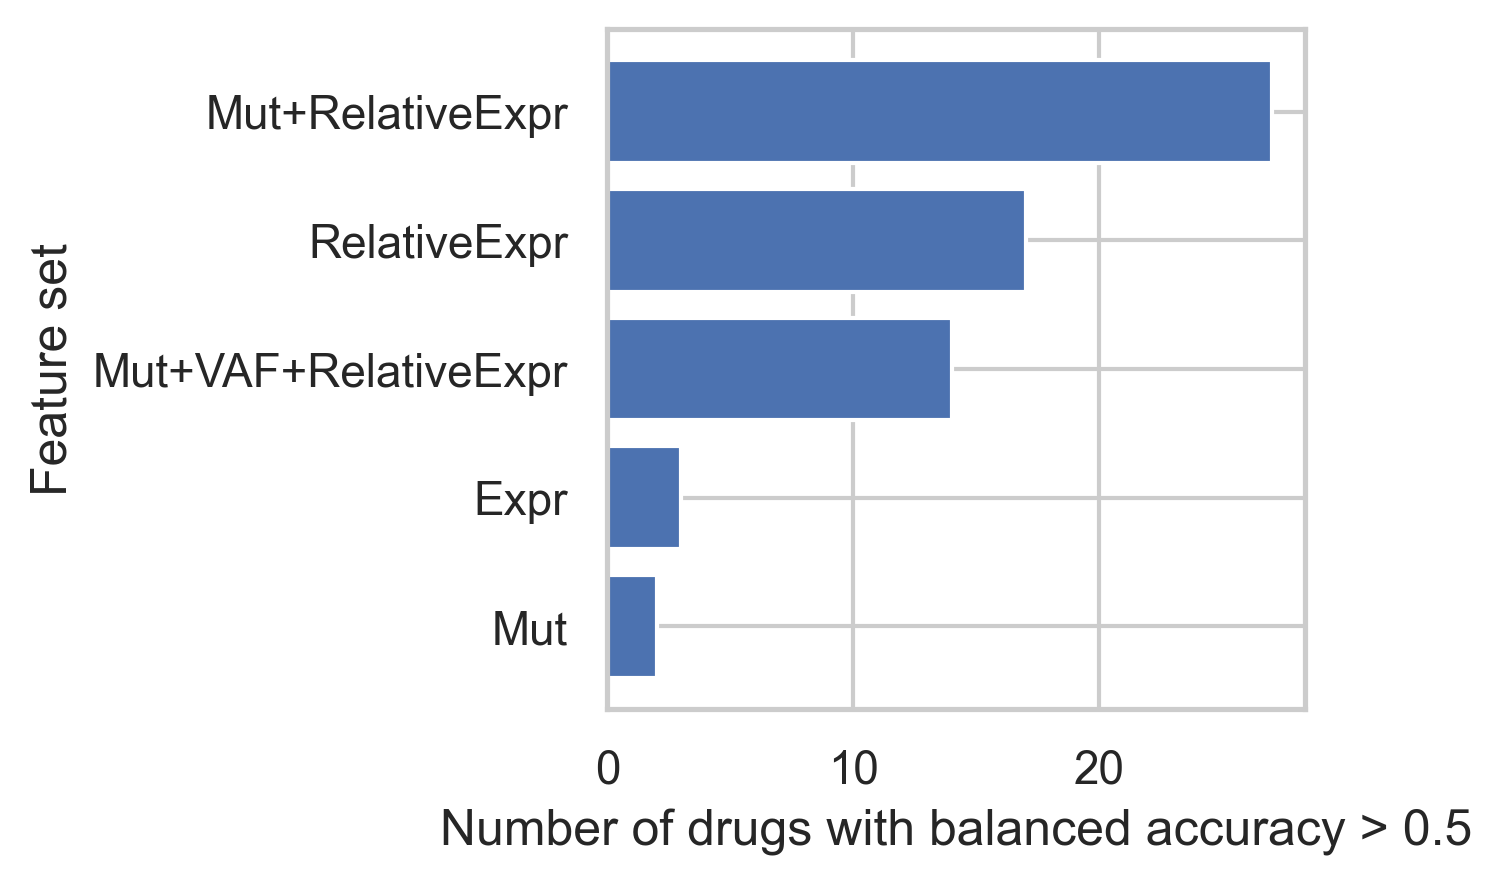

In [70]:
count_by_feature_w12 = optimized_result_w12.groupby(["Feature"]).count()
# barplot 

count_by_feature_w12.sort_values(by = ['ACC_w1_2'], ascending = True)
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.figure(figsize=(3, 3), dpi=300)
plt.barh(count_by_feature_w12.sort_values(by = ['ACC_w1_2'], ascending = True).index, count_by_feature_w12.sort_values(by = ['ACC_w1_2'], ascending = True)['ACC_w1_2'])
plt.xlabel("Number of drugs with balanced accuracy > 0.5")
plt.ylabel("Feature set")

Text(0, 0.5, 'Feature set')

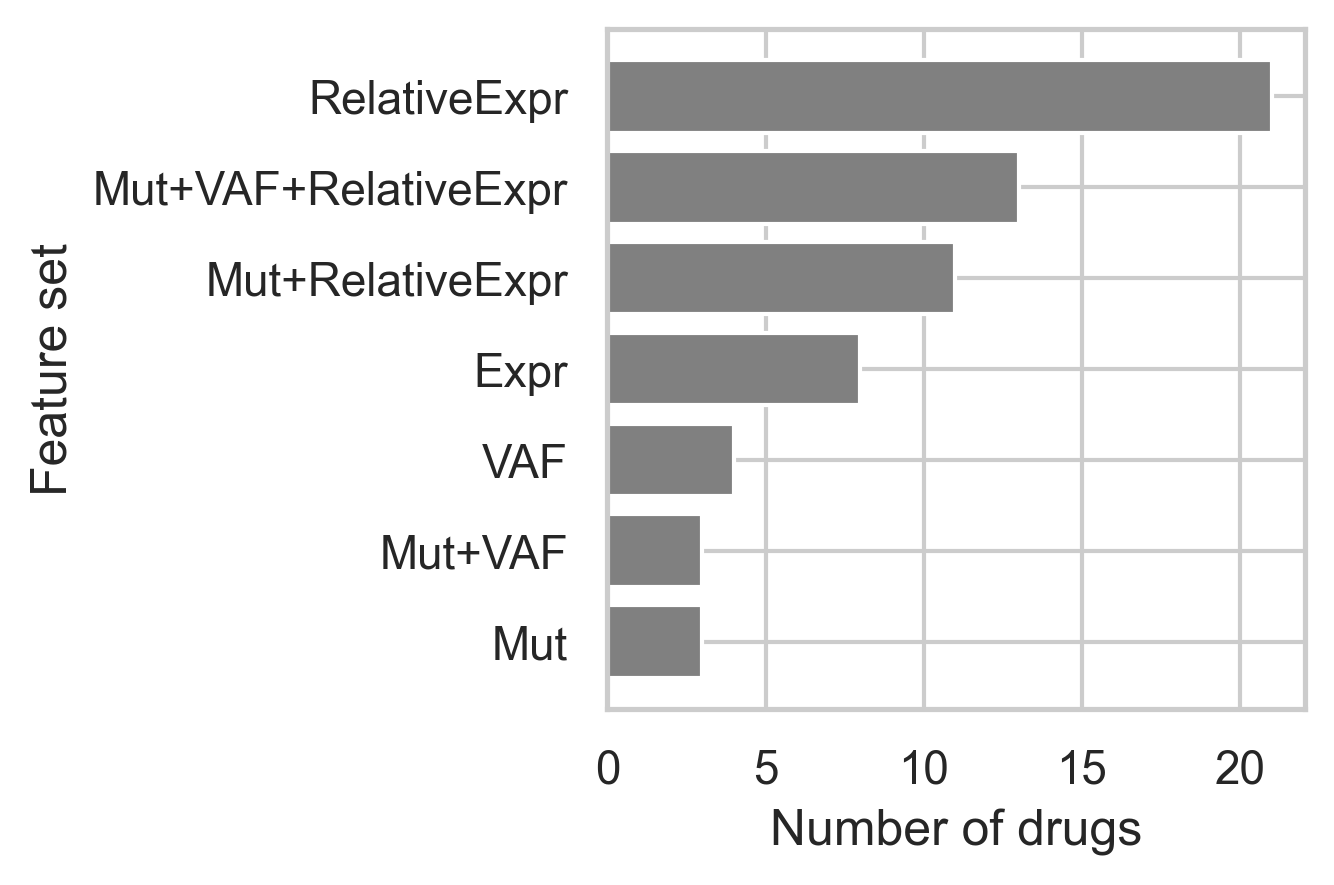

In [76]:
count_by_feature = optimized_result.groupby(["Feature"]).count()
# barplot 

count_by_feature.sort_values(by = ['ACC_w3_4'], ascending = True)
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.figure(figsize=(3, 3), dpi=300)
plt.barh(count_by_feature.sort_values(by = ['ACC_w3_4'], ascending = True).index, 
         count_by_feature.sort_values(by = ['ACC_w3_4'], ascending = True)['ACC_w3_4'],
         color = "grey")
plt.xlabel("Number of drugs")
plt.ylabel("Feature set")

In [71]:
optimized_result

,Drug,Threshold,Drug,Feature,Drug,ACC_w3_4
57,Venetoclax,1.452619,Venetoclax,RelativeExpr,Venetoclax,0.776035
16,JNJ-28312141,0.344753,JNJ-28312141,RelativeExpr,JNJ-28312141,0.740260
1,Linifanib (ABT-869),3.871858,Linifanib (ABT-869),Mut+RelativeExpr,Linifanib (ABT-869),0.735646
29,Trametinib (GSK1120212),1.000000,Trametinib (GSK1120212),Mut+RelativeExpr,Trametinib (GSK1120212),0.734923
31,Rapamycin,1.000000,Rapamycin,Mut+VAF+RelativeExpr,Rapamycin,0.721998
...,...,...,...,...,...,...
5,PI-103,1.169738,PI-103,Mut,PI-103,0.559268
44,Vatalanib (PTK787),5.273658,Vatalanib (PTK787),Mut+RelativeExpr,Vatalanib (PTK787),0.550789
15,AZD1480,5.461353,AZD1480,Mut+VAF,AZD1480,0.541193
42,GSK-1838705A,3.559073,GSK-1838705A,Mut+VAF,GSK-1838705A,0.531880


Text(0, 0.5, 'Feature set')

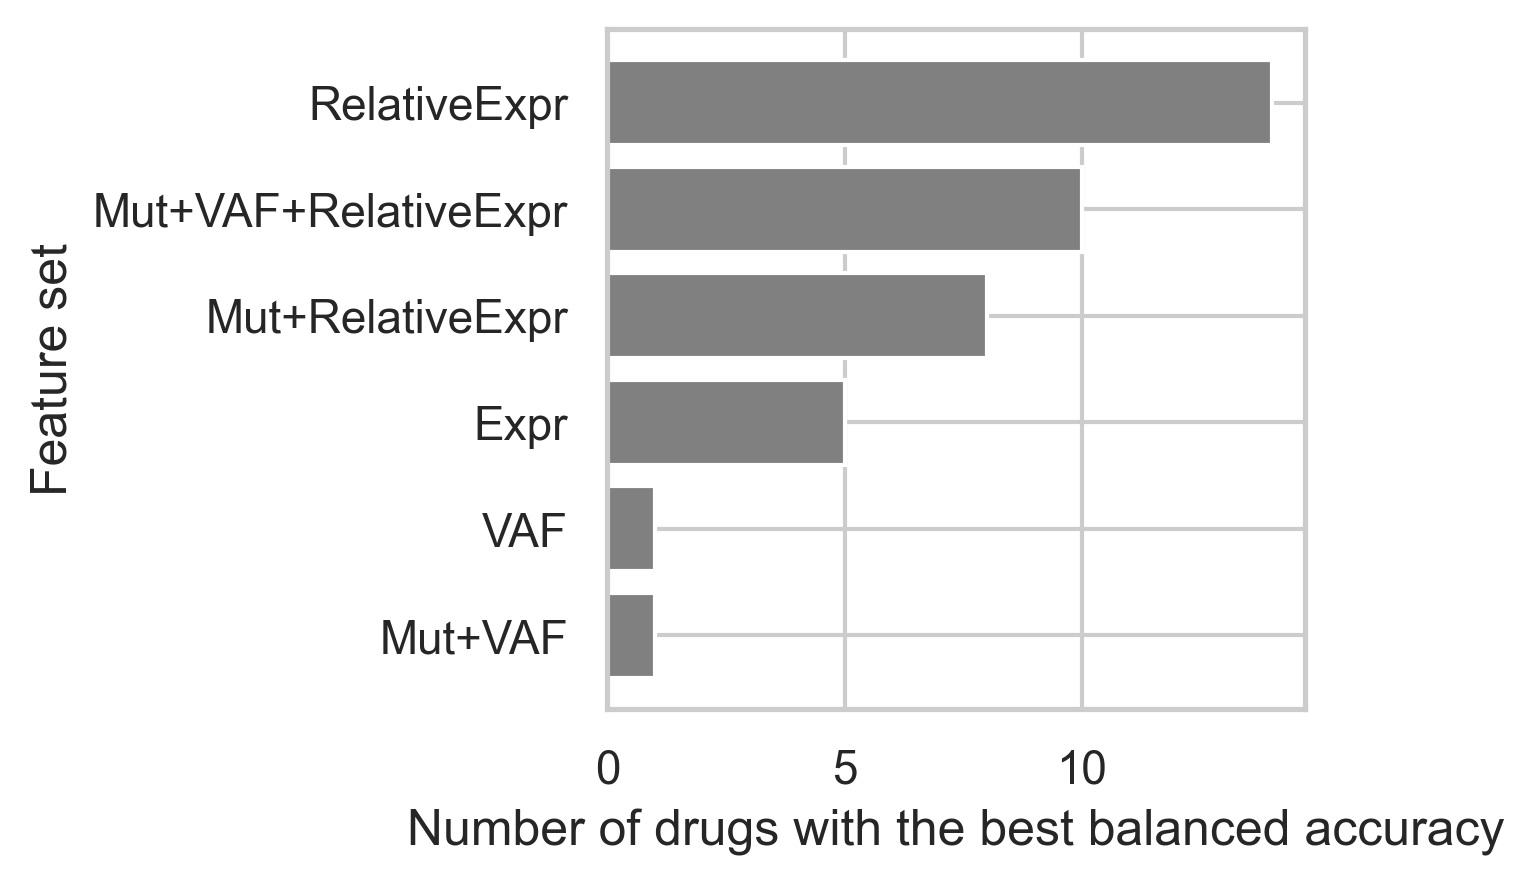

In [77]:
count_by_feature = optimized_result.loc[optimized_result['ACC_w3_4'] >0.6].groupby(["Feature"]).count()
# barplot 

count_by_feature.sort_values(by = ['ACC_w3_4'], ascending = True)
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.figure(figsize=(3, 3), dpi=300)
plt.barh(count_by_feature.sort_values(by = ['ACC_w3_4'], ascending = True).index, 
         count_by_feature.sort_values(by = ['ACC_w3_4'], ascending = True)['ACC_w3_4'],
         color = "grey")
plt.xlabel("Number of drugs with the best balanced accuracy")
plt.ylabel("Feature set")

In [78]:
sele_threshold = optimized_result['Threshold']

In [87]:
optimized_result['Drug'].iloc[:,0]

57                 Venetoclax
16               JNJ-28312141
1         Linifanib (ABT-869)
29    Trametinib (GSK1120212)
31                  Rapamycin
               ...           
5                      PI-103
44         Vatalanib (PTK787)
15                    AZD1480
42               GSK-1838705A
52        Cediranib (AZD2171)
Name: Drug, Length: 63, dtype: object

In [104]:
optimized_result_0_6= optimized_result.loc[optimized_result['ACC_w3_4'] > 0.6]

In [105]:
optimized_result

dic_threshold = {}
drugs_list_c = list(optimized_result_0_6['Drug'].iloc[:,0].values)
threshold_list_c = list(optimized_result_0_6['Threshold'].values)
for  i in range(0, len(drugs_list_c)):
    dic_threshold[drugs_list_c[i]] = threshold_list_c[i]
dic_threshold

{'Venetoclax': 1.45261900330956,
 'JNJ-28312141': 0.344752721587226,
 'Linifanib (ABT-869)': 3.8718575225118297,
 'Trametinib (GSK1120212)': 1.0,
 'Rapamycin': 1.0,
 'Dasatinib': 0.4576859536358775,
 '17-AAG (Tanespimycin)': 0.492055058020077,
 'AT7519': 0.520213366464784,
 'Axitinib (AG-013736)': 4.7424604696408,
 'SNS-032 (BMS-387032)': 0.113084129857264,
 'Selumetinib (AZD6244)': 1.0,
 'Foretinib (XL880)': 1.0,
 'MK-2206': 1.295579266519115,
 'Ponatinib (AP24534)': 0.01458367171380795,
 'Sorafenib': 0.7619831899135108,
 'CI-1040 (PD184352)': 2.40296001561038,
 'Dovitinib (CHIR-258)': 0.626497217524282,
 'KW-2449': 9.17876749093365,
 'GDC-0941': 0.582985880849037,
 'MGCD-265': 8.55932103261071,
 'KI20227': 5.0585208666304595,
 'Tivozanib (AV-951)': 1.01657736172738,
 'Vargetef': 1.632504597942185,
 'Crenolanib': 3.02157500105766,
 'PRT062607': 2.44545797483487,
 'Pelitinib (EKB-569)': 0.681352829586919,
 'Sunitinib': 0.12041116643704,
 'Cabozantinib': 1.2896139731094,
 'Midostaurin':

In [ ]:
optimized_result

dic_threshold = {}
drugs_list_c = list(optimized_result_0_6['Drug'].iloc[:,0].values)
threshold_list_c = list(optimized_result_0_6['Threshold'].values)
for  i in range(0, len(drugs_list_c)):
    dic_threshold[drugs_list_c[i]] = threshold_list_c[i]
dic_threshold

In [106]:
sele_df = pd.DataFrame()
for drug in dic_threshold.keys():
    cur_sele = r.loc[r['Drug'] == drug]
    cur_sele = cur_sele.loc[cur_sele['Threshold'] == dic_threshold[drug]]
    sele_df = pd.concat([sele_df,cur_sele], axis = 0)

sele_df 

,Drug,Threshold,Feature,ACC_train,F1_train,ACC1_2,ACC_w3_4,F1_w1_2,F1_w3_4
10220,Venetoclax,1.452619,Mut,0.806613,0.813397,0.422727,0.596348,0.500000,0.579235
10221,Venetoclax,1.452619,Mut,0.770016,0.792793,0.754545,0.518261,0.800000,0.560000
10222,Venetoclax,1.452619,Mut,0.789466,0.792271,0.472727,0.602066,0.521739,0.564972
10223,Venetoclax,1.452619,Mut,0.763925,0.775701,0.568182,0.579378,0.608696,0.582011
10224,Venetoclax,1.452619,Mut,0.767007,0.783410,0.477273,0.607600,0.476190,0.590164
...,...,...,...,...,...,...,...,...,...
4405,PP242,0.933293,Mut+VAF+RelativeExpr,1.000000,1.000000,0.500000,0.568696,0.857143,0.891473
4406,PP242,0.933293,Mut+VAF+RelativeExpr,1.000000,1.000000,0.500000,0.548696,0.789474,0.869565
4407,PP242,0.933293,Mut+VAF+RelativeExpr,1.000000,1.000000,0.722222,0.525217,0.894737,0.884615
4408,PP242,0.933293,Mut+VAF+RelativeExpr,1.000000,1.000000,0.777778,0.556696,0.888889,0.878431


In [120]:
improved_drugs = optimized_result.loc[optimized_result['Feature'].isin(["RelativeExpr","Mut+RelativeExpr","Mut+VAF+RelativeExpr"])]['Drug'].iloc[:,0].values
other_drugs = optimized_result.loc[~optimized_result['Feature'].isin(["RelativeExpr","Mut+RelativeExpr","Mut+VAF+RelativeExpr"])]['Drug'].iloc[:,0].values

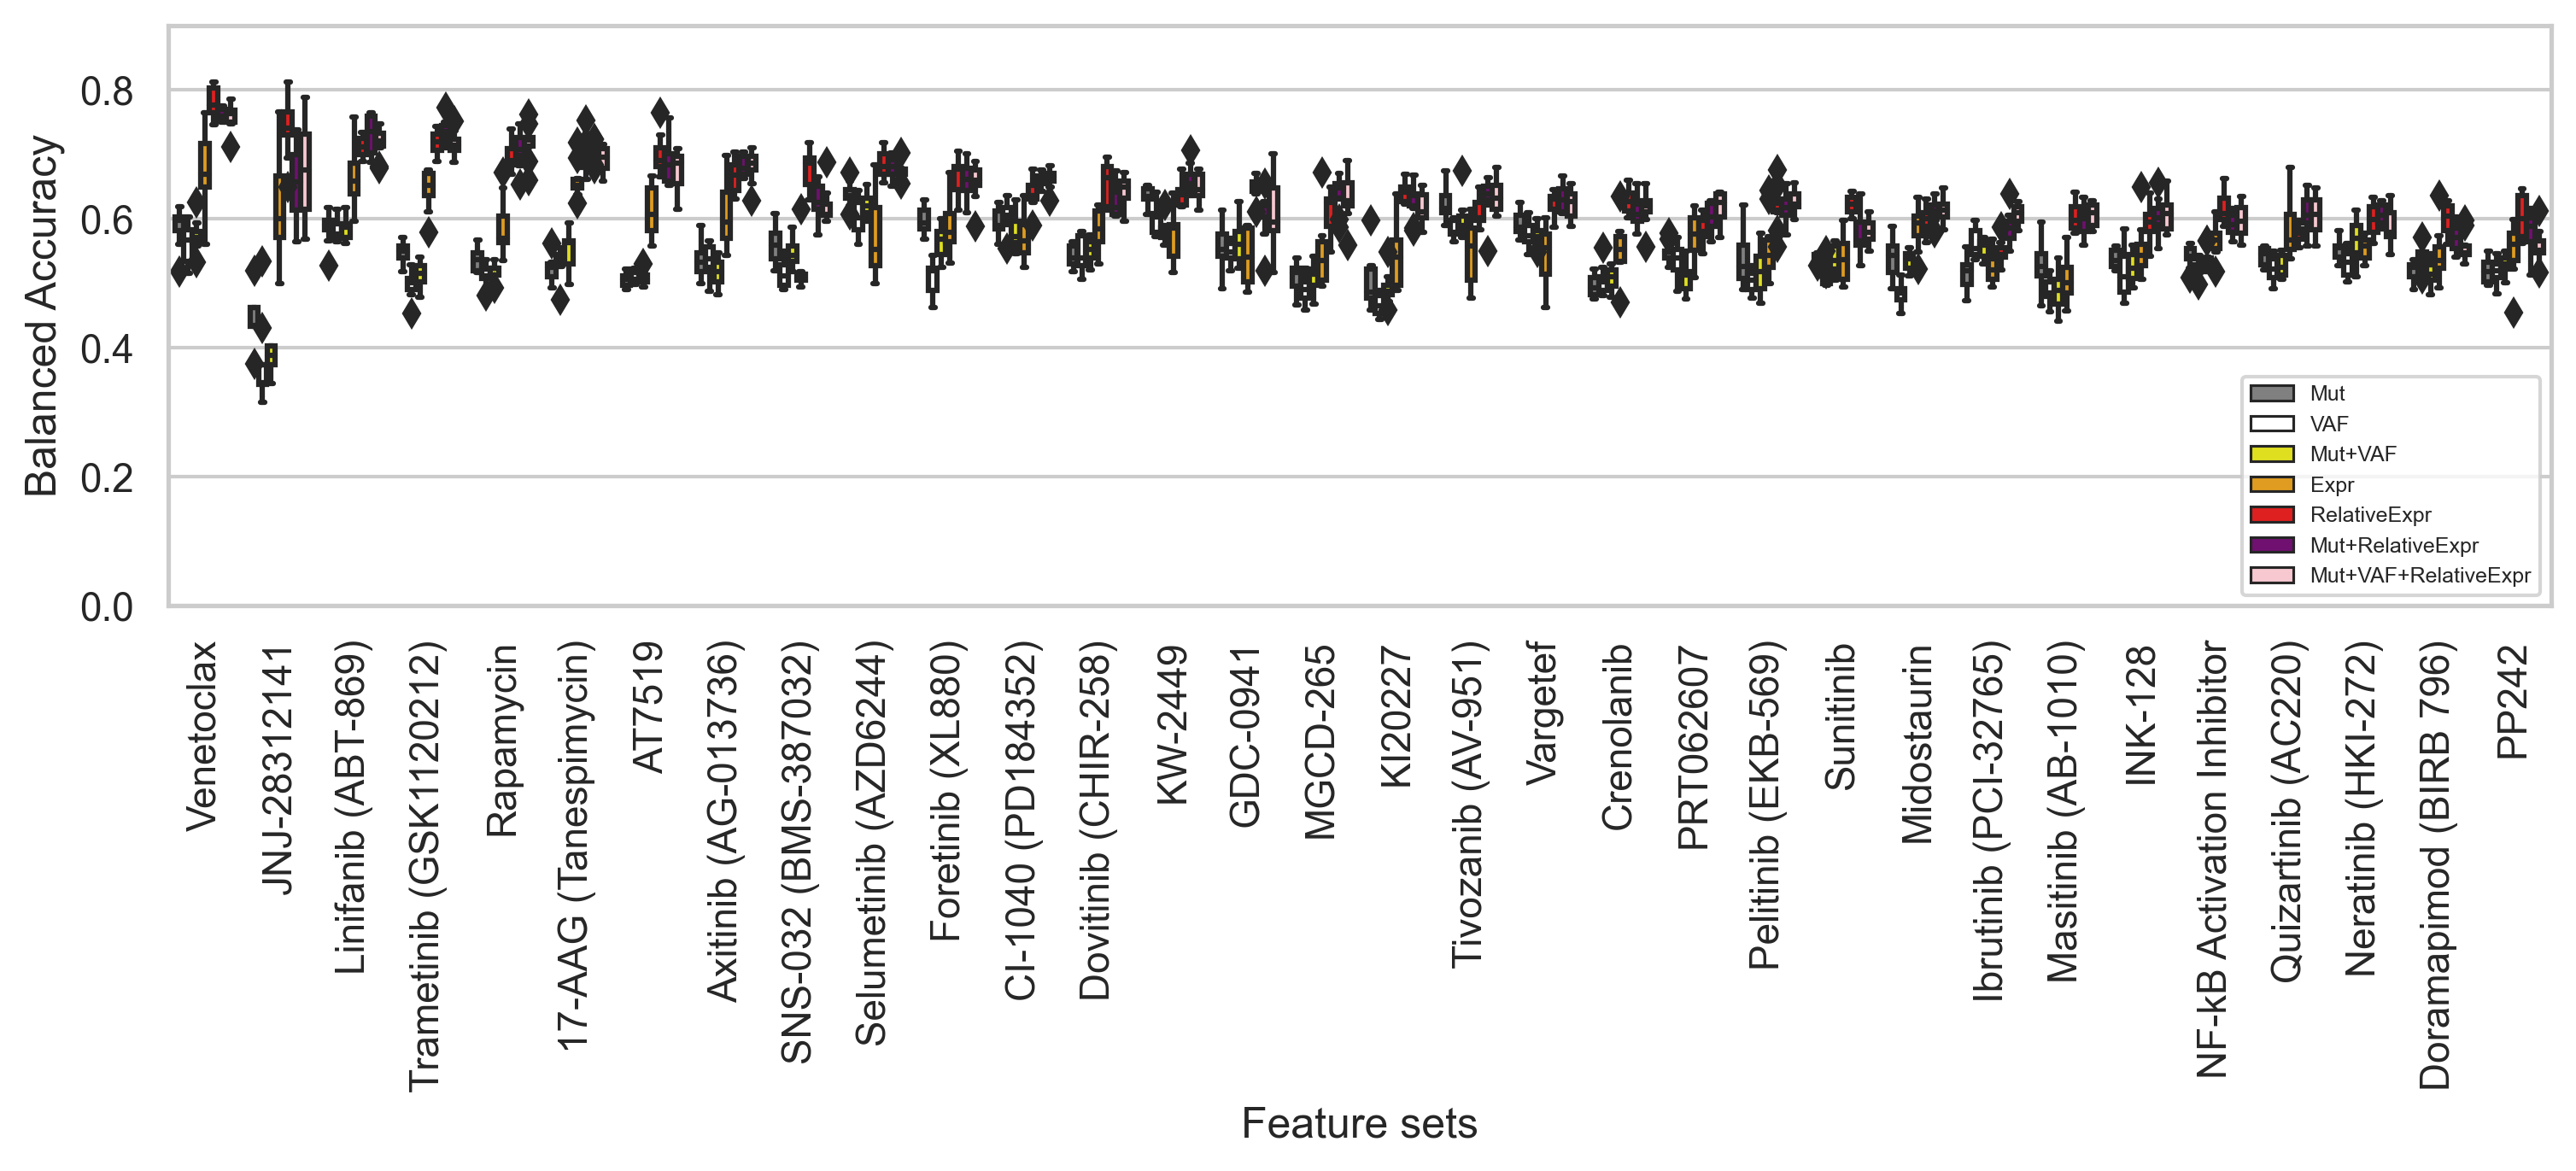

In [125]:
plt.figure(figsize = (12,3),dpi = 300)
sns.boxplot(x="Drug", y="ACC_w3_4",
                hue="Feature", palette=["grey","white","yellow","orange" ,"red","purple","pink"],
                data=sele_df.loc[sele_df['Drug'].isin(improved_drugs)])
xticks_locs, xticks_labels = plt.xticks()
#for i in range(0,len(xticks_labels)):
#    xticks_labels[i] = str(round(float(xticks_labels[i].get_text()),2)) + "μM"

plt.xticks(xticks_locs, xticks_labels, rotation = 90)
plt.ylim(0,0.9)
plt.legend(fontsize = 6)
#plt.title(Drug.split("(")[0]+" (Beat AML Wave 3/4)" )
    #threshold_list_label = ["set1","set3","set4","set1&4"]

plt.ylabel("Balanced Accuracy")
plt.xlabel("Feature sets")
plt.show()

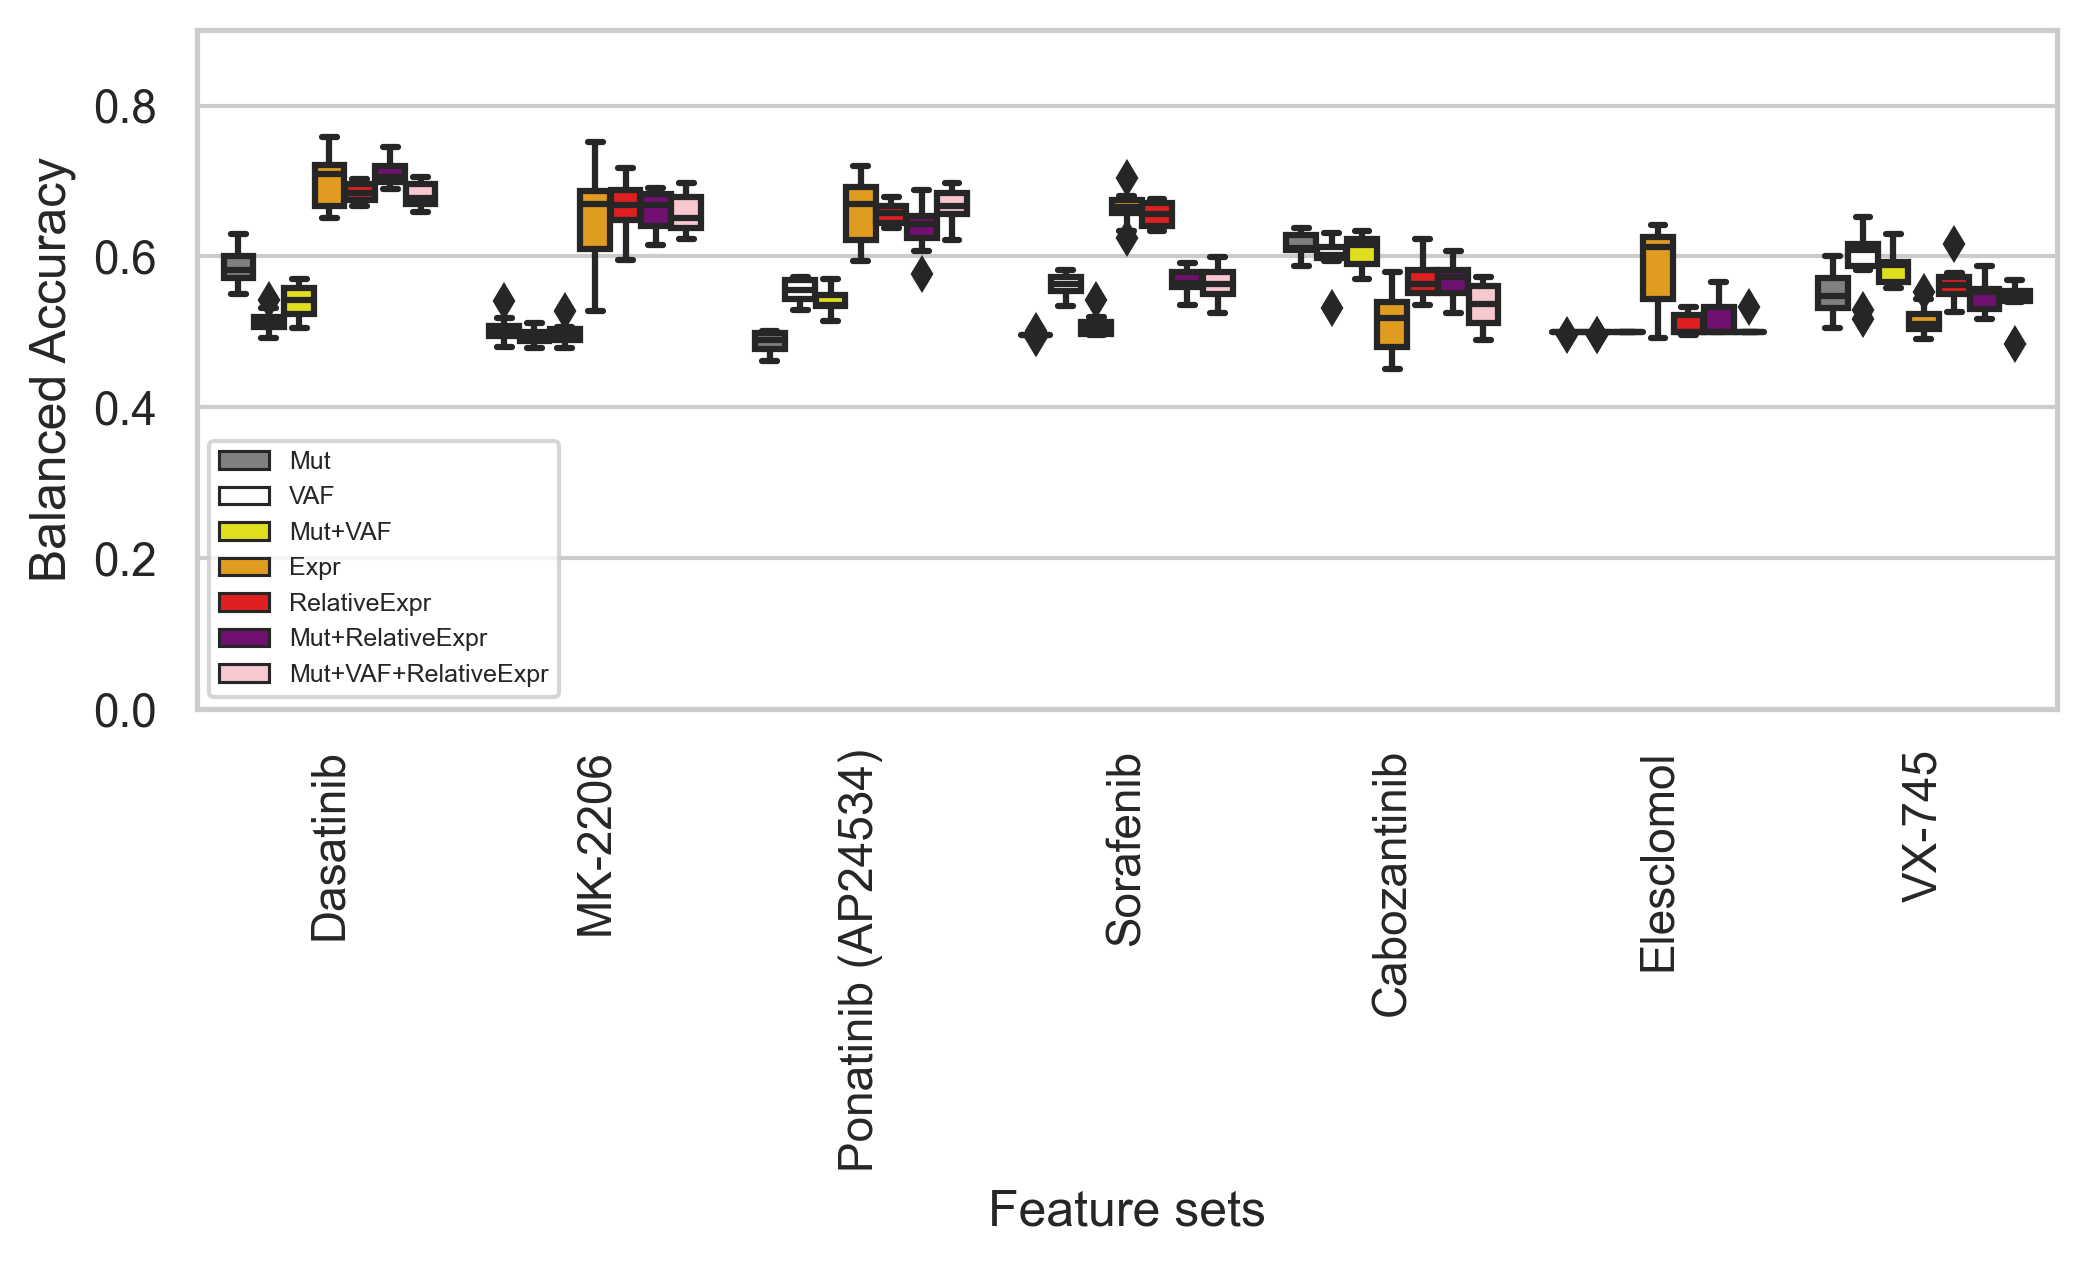

In [124]:
plt.figure(figsize = (8,3),dpi = 300)
sns.boxplot(x="Drug", y="ACC_w3_4",
                hue="Feature", palette=["grey","white","yellow","orange" ,"red","purple","pink"],
                data=sele_df.loc[sele_df['Drug'].isin(other_drugs)])
xticks_locs, xticks_labels = plt.xticks()
#for i in range(0,len(xticks_labels)):
#    xticks_labels[i] = str(round(float(xticks_labels[i].get_text()),2)) + "μM"

plt.xticks(xticks_locs, xticks_labels, rotation = 90)
plt.ylim(0,0.9)
plt.legend(fontsize = 6)
#plt.title(Drug.split("(")[0]+" (Beat AML Wave 3/4)" )
    #threshold_list_label = ["set1","set3","set4","set1&4"]

plt.ylabel("Balanced Accuracy")
plt.xlabel("Feature sets")
plt.show()

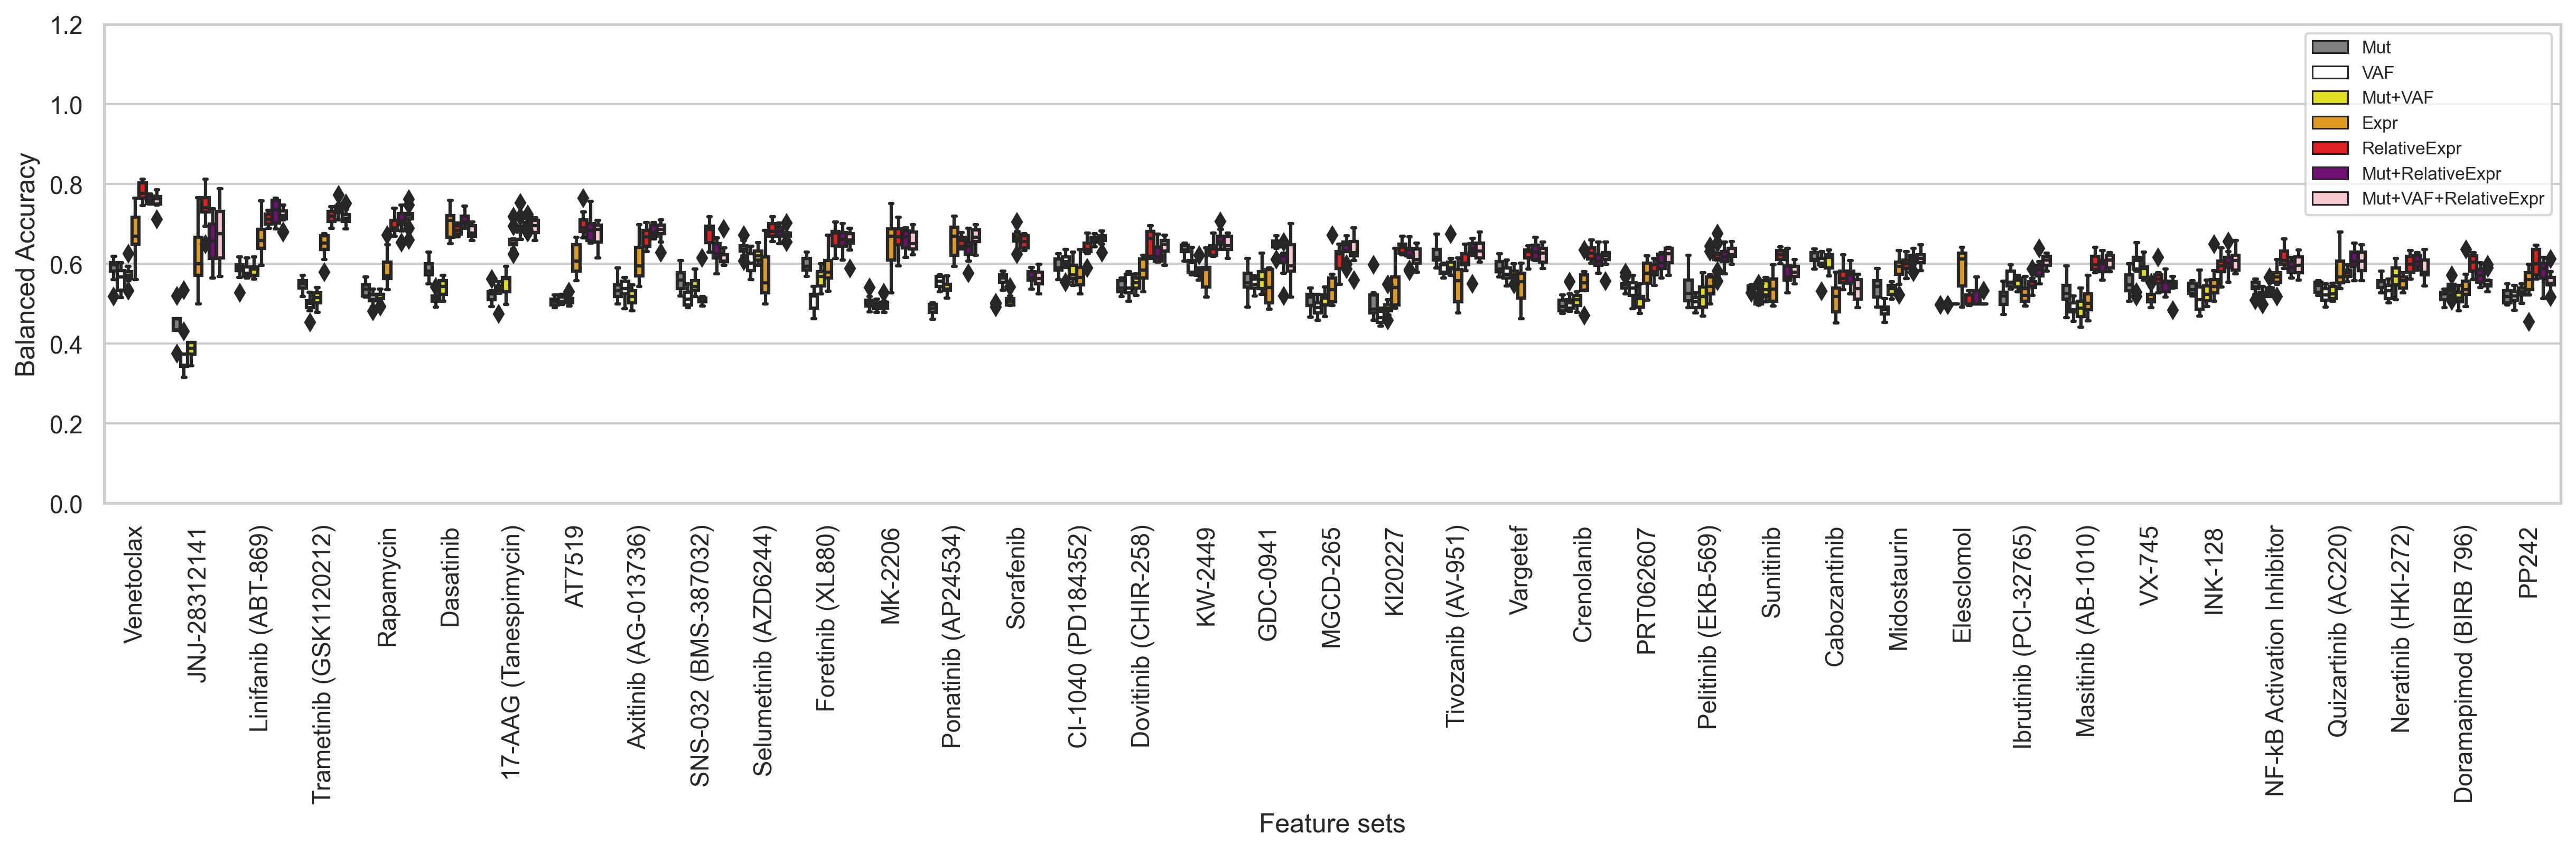

In [126]:
plt.figure(figsize = (20,4),dpi = 300)
sns.boxplot(x="Drug", y="ACC_w3_4",
                hue="Feature", palette=["grey","white","yellow","orange" ,"red","purple","pink"],
                data=sele_df)
xticks_locs, xticks_labels = plt.xticks()
#for i in range(0,len(xticks_labels)):
#    xticks_labels[i] = str(round(float(xticks_labels[i].get_text()),2)) + "μM"

plt.xticks(xticks_locs, xticks_labels, rotation = 90)
plt.ylim(0,1.2)
plt.legend(fontsize = 8)
#plt.title(Drug.split("(")[0]+" (Beat AML Wave 3/4)" )
    #threshold_list_label = ["set1","set3","set4","set1&4"]

plt.ylabel("Balanced Accuracy")
plt.xlabel("Feature sets")
plt.show()

# result_with_threshod are the results for all prediction models

In [99]:
#### Get the accuracy matrix

In [219]:
# Get feature importance
result_with_threshod['Idelalisib'][0.947315102397624].keys()

dict_keys(['Mut', 'VAF', 'Mut+VAF', 'Expr', 'RelativeExpr', 'Mut+RelativeExpr', 'Mut+VAF+RelativeExpr'])

In [220]:
optimized_result

dic_threshold = {}
drugs_list_c = list(optimized_result['Drug'].iloc[:,0].values)
threshold_list_c = list(optimized_result['Threshold'].values)
for  i in range(0, len(drugs_list_c)):
    dic_threshold[drugs_list_c[i]] = threshold_list_c[i]
print(len(dic_threshold.keys()))

63


In [204]:
feature_set = ['RelativeExpr','Mut+RelativeExpr','Mut+VAF+RelativeExpr']
feature_drug_df = pd.DataFrame()
for feature_sele in feature_set:
    for drug in dic_threshold.keys():
        print(drug)
        test = result_with_threshod[drug]
        cur = test[dic_threshold[drug]]
        feature_df = pd.DataFrame()
        for random in cur[feature_sele]:
            if cur[feature_sele][random]['blanced_acc_independent'] > 0.6 :
                feature_df_cur = cur[feature_sele][random]['features']
                feature_df_cur["IMP_"+str(random)]  = feature_df_cur['IMP']
                feature_df_cur.index = feature_df_cur['Feature']
                feature_df = pd.concat([feature_df, feature_df_cur["IMP_"+str(random)] ], axis =1)
        feature_df_sum = feature_df.sum(axis = 1)/feature_df.shape[1]
        result = pd.DataFrame({"features":feature_df_sum.index, 
                                "IMP":feature_df_sum.values, 
                                "Drug":[drug]*len(feature_df_sum.index),
                                "Feature":[feature_sele]*len(feature_df_sum.index)
                            })
        
        feature_drug_df = pd.concat([feature_drug_df, result])

Venetoclax
JNJ-28312141
Linifanib (ABT-869)
Trametinib (GSK1120212)
Rapamycin
Dasatinib
17-AAG (Tanespimycin)
AT7519
Axitinib (AG-013736)
SNS-032 (BMS-387032)
Selumetinib (AZD6244)
Foretinib (XL880)
MK-2206
Ponatinib (AP24534)
Sorafenib
CI-1040 (PD184352)
Dovitinib (CHIR-258)
KW-2449
GDC-0941
MGCD-265
KI20227
Tivozanib (AV-951)
Vargetef
Crenolanib
PRT062607
Pelitinib (EKB-569)
Sunitinib
Cabozantinib
Midostaurin
Elesclomol
Ibrutinib (PCI-32765)
Masitinib (AB-1010)
VX-745
INK-128
NF-kB Activation Inhibitor
Quizartinib (AC220)
Neratinib (HKI-272)
Doramapimod (BIRB 796)
PP242
Panobinostat
Idelalisib
NVP-TAE684
Flavopiridol
PD173955
RAF265 (CHIR-265)
BEZ235
Bosutinib (SKI-606)
A-674563
Selinexor
Motesanib (AMG-706)
CYT387
Pazopanib (GW786034)
JAK Inhibitor I
Vandetanib (ZD6474)
Tofacitinib (CP-690550)
Lestaurtinib (CEP-701)
Bortezomib (Velcade)
JQ1
PI-103
Vatalanib (PTK787)
AZD1480
GSK-1838705A
Cediranib (AZD2171)
Venetoclax
JNJ-28312141
Linifanib (ABT-869)
Trametinib (GSK1120212)
Rapamycin

In [206]:
feature_drug_df.to_csv("../Data/feature_importance_all_drugs_bacc0.6.csv")

In [230]:
feature_set = ['RelativeExpr','Mut+RelativeExpr','Mut+VAF+RelativeExpr']
feature_drug_df = pd.DataFrame()
for feature_sele in feature_set:
    for drug in dic_threshold.keys():
        print(drug)
        test = result_with_threshod[drug]
        cur = test[dic_threshold[drug]]
        feature_df = pd.DataFrame()
        for random in cur[feature_sele]:
            if cur[feature_sele][random]['blanced_acc_independent'] > 0.7 :
                feature_df_cur = cur[feature_sele][random]['features']
                feature_df_cur["IMP_"+str(random)]  = feature_df_cur['IMP']
                feature_df_cur.index = feature_df_cur['Feature']
                feature_df = pd.concat([feature_df, feature_df_cur["IMP_"+str(random)] ], axis =1)
        feature_df_sum = feature_df.sum(axis = 1)/feature_df.shape[1]
        result = pd.DataFrame({"features":feature_df_sum.index, 
                            "IMP":feature_df_sum.values, 
                            "Drug":[drug]*len(feature_df_sum.index),
                            "Feature":[feature_sele]*len(feature_df_sum.index)
                            })
        
        feature_drug_df = pd.concat([feature_drug_df, result])

Venetoclax
JNJ-28312141
Linifanib (ABT-869)
Trametinib (GSK1120212)
Rapamycin
Dasatinib
17-AAG (Tanespimycin)
AT7519
Axitinib (AG-013736)
SNS-032 (BMS-387032)
Selumetinib (AZD6244)
Foretinib (XL880)
MK-2206
Ponatinib (AP24534)
Sorafenib
CI-1040 (PD184352)
Dovitinib (CHIR-258)
KW-2449
GDC-0941
MGCD-265
KI20227
Tivozanib (AV-951)
Vargetef
Crenolanib
PRT062607
Pelitinib (EKB-569)
Sunitinib
Cabozantinib
Midostaurin
Elesclomol
Ibrutinib (PCI-32765)
Masitinib (AB-1010)
VX-745
INK-128
NF-kB Activation Inhibitor
Quizartinib (AC220)
Neratinib (HKI-272)
Doramapimod (BIRB 796)
PP242
Panobinostat
Idelalisib
NVP-TAE684
Flavopiridol
PD173955
RAF265 (CHIR-265)
BEZ235
Bosutinib (SKI-606)
A-674563
Selinexor
Motesanib (AMG-706)
CYT387
Pazopanib (GW786034)
JAK Inhibitor I
Vandetanib (ZD6474)
Tofacitinib (CP-690550)
Lestaurtinib (CEP-701)
Bortezomib (Velcade)
JQ1
PI-103
Vatalanib (PTK787)
AZD1480
GSK-1838705A
Cediranib (AZD2171)
Venetoclax
JNJ-28312141
Linifanib (ABT-869)
Trametinib (GSK1120212)
Rapamycin

In [231]:
feature_drug_df.to_csv("../Data/feature_importance_all_drugs_bacc0.7.csv")

In [232]:
feature_drug_df_0_01 = feature_drug_df.loc[feature_drug_df['IMP'] > 0.01]
feature_drug_df_0_01.to_csv("../Data/feature_importance_all_drugs_bacc0.7_0.01.csv")

In [209]:
feature_drug_df_0_0_1 = feature_drug_df.loc[feature_drug_df['IMP'] > 0.01]
feature_drug_df_0_0_1.to_csv("../Data/feature_importance_includeRelativeExpr_0.01_bcc0.7.csv")

In [280]:
#feature_drug_df.loc[feature_drug_df['Drug'] == "JQ1"].sort_values(by = ['IMP'], ascending = False).head(10)

In [210]:
feature_drug_df_sig = feature_drug_df_0_0_1

In [211]:
feature_drug_df_sig
drug_family = ["Bosutinib (SKI-606)", "Dasatinib","Imatinib","Nilotinib","PD173955","Ponatinib (AP24534)"]
features_sele = feature_drug_df_sig.loc[feature_drug_df_sig['Drug'].isin(drug_family)]
feature_list_sele = []
for feature in set(features_sele['features']):
    if features_sele.loc[features_sele['features'] == feature].shape[0]>=2:
        feature_list_sele.append(feature)

feature_common = features_sele.loc[features_sele['features'].isin(feature_list_sele)]
feature_common['Drug_Family'] = ['ABL']*feature_common.shape[0]

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/781259054.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_common['Drug_Family'] = ['ABL']*feature_common.shape[0]


In [128]:
feature_common.to_csv("ABL_family_common_features.csv")

In [213]:
#CDK4_6 or pan-CDK predictors
feature_drug_df_sig
drug_family = ["AT7519", "Flavopiridol", "Palbociclib", "BMS-35541", "JNJ-776621", "Roscovitine (CYC-202)",  "SNS-032 (BMS-387032)"]
features_sele = feature_drug_df_sig.loc[feature_drug_df_sig['Drug'].isin(drug_family)]
feature_list_sele = []
for feature in set(features_sele['features']):
    if features_sele.loc[features_sele['features'] == feature].shape[0]>=2:
        feature_list_sele.append(feature)

feature_common = features_sele.loc[features_sele['features'].isin(feature_list_sele)]
feature_common['Drug_Family'] = ['pan-CDK']*feature_common.shape[0]

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/1873044831.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_common['Drug_Family'] = ['pan-CDK']*feature_common.shape[0]


In [214]:
feature_common

,features,IMP,Drug,Feature,Drug_Family
0,ABCB1-COX6A1,0.036568,AT7519,RelativeExpr,pan-CDK
1,C12orf57-SF3B2,0.023834,AT7519,RelativeExpr,pan-CDK
2,FAM129B-RPS10,0.012004,AT7519,RelativeExpr,pan-CDK
8,IL1R1-RPS10,0.010201,AT7519,RelativeExpr,pan-CDK
9,HDAC5-ZBTB7A,0.012696,AT7519,RelativeExpr,pan-CDK
23,HDAC5-E2F4,0.011584,AT7519,RelativeExpr,pan-CDK
176,SRSF8-FNTA,0.012555,AT7519,RelativeExpr,pan-CDK
0,ABCB1-COX6A1,0.037830,AT7519,Mut+RelativeExpr,pan-CDK
1,C12orf57-SF3B2,0.025348,AT7519,Mut+RelativeExpr,pan-CDK
3,SRSF8-FNTA,0.011897,AT7519,Mut+RelativeExpr,pan-CDK


In [130]:
feature_common.to_csv("pan_CDK_family_common_features.csv")

In [215]:
#RAF_MEK_ERK inhibitor
feature_drug_df_sig
drug_family = ["CL-1040 (PD184352)", "GDC-0879", "PD173955", "RAF265 (CHIR-265)", "Regorafenib (BAY 73-4506)", "Selumetinib (AZD6244)", "Trametinib (GSK1120212)", "Vemurafenib (PLX-4032)"]
features_sele = feature_drug_df_sig.loc[feature_drug_df_sig['Drug'].isin(drug_family)]
feature_list_sele = []
for feature in set(features_sele['features']):
    if features_sele.loc[features_sele['features'] == feature].shape[0]>=2:
        feature_list_sele.append(feature)

feature_common = features_sele.loc[features_sele['features'].isin(feature_list_sele)]
feature_common['Drug_Family'] = ['RAF_MEK_ERK']*feature_common.shape[0]

feature_common

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/1571657380.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_common['Drug_Family'] = ['RAF_MEK_ERK']*feature_common.shape[0]


,features,IMP,Drug,Feature,Drug_Family
2,ARHGAP18-FNTA,0.019507,Trametinib (GSK1120212),RelativeExpr,RAF_MEK_ERK
4,PCBP3-FNTA,0.019665,Trametinib (GSK1120212),RelativeExpr,RAF_MEK_ERK
5,CA2-COX6A1,0.015159,Trametinib (GSK1120212),RelativeExpr,RAF_MEK_ERK
8,AC079325.6-MIR4519,0.013454,Trametinib (GSK1120212),RelativeExpr,RAF_MEK_ERK
147,AC079325.6-MIR623,0.010767,Trametinib (GSK1120212),RelativeExpr,RAF_MEK_ERK
0,CD300E-COX6A1,0.024153,Selumetinib (AZD6244),RelativeExpr,RAF_MEK_ERK
1,LRP1-FOXK1,0.023432,Selumetinib (AZD6244),RelativeExpr,RAF_MEK_ERK
3,DST-ZFHX3,0.017892,Selumetinib (AZD6244),RelativeExpr,RAF_MEK_ERK
6,CA2-MIR5690,0.012422,Selumetinib (AZD6244),RelativeExpr,RAF_MEK_ERK
7,SIGLEC16-MIR643,0.034144,Selumetinib (AZD6244),RelativeExpr,RAF_MEK_ERK


In [132]:
#feature_common
feature_common.to_csv("RAF_MEK_ERK_family_common_features.csv")

In [216]:
#RAF_MEK_ERK inhibitor
feature_drug_df_sig
drug_family = ["Venetoclax","ABT737","ABT263","ABT199"]
features_sele = feature_drug_df_sig.loc[feature_drug_df_sig['Drug'].isin(drug_family)]
feature_list_sele = []
for feature in set(features_sele['features']):
    if features_sele.loc[features_sele['features'] == feature].shape[0]>=2:
        feature_list_sele.append(feature)

feature_common = features_sele.loc[features_sele['features'].isin(feature_list_sele)]
feature_common['Drug_Family'] = ['BCL2 family inhibitor']*feature_common.shape[0]
feature_common
#feature_common.to_csv("BCL2_family_common_features.csv")

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_22595/3844969171.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_common['Drug_Family'] = ['BCL2 family inhibitor']*feature_common.shape[0]


,features,IMP,Drug,Feature,Drug_Family
0,FGD4-MIR4519,0.105847,Venetoclax,RelativeExpr,BCL2 family inhibitor
1,GDF11-RBPJ,0.018531,Venetoclax,RelativeExpr,BCL2 family inhibitor
2,MTSS1-FNTA,0.022235,Venetoclax,RelativeExpr,BCL2 family inhibitor
3,BCL2-BECN1,0.019745,Venetoclax,RelativeExpr,BCL2 family inhibitor
6,CASC10-POU6F1,0.021972,Venetoclax,RelativeExpr,BCL2 family inhibitor
7,NPC2-CTCF,0.018671,Venetoclax,RelativeExpr,BCL2 family inhibitor
13,ECHDC3-MIR940,0.015620,Venetoclax,RelativeExpr,BCL2 family inhibitor
18,NPC2-GATA2,0.021834,Venetoclax,RelativeExpr,BCL2 family inhibitor
30,FGD4-RPS10,0.013563,Venetoclax,RelativeExpr,BCL2 family inhibitor
155,GDF11-COX6A1,0.011543,Venetoclax,RelativeExpr,BCL2 family inhibitor


In [532]:
# Visulize the effect of predictors and drug response